In [1329]:
%load_ext autoreload
%autoreload 2
import sys
# sys.path.append("D:/Github/note/module")                        # for windows
sys.path.append("/Users/xinc./Documents/GitHub/note/module")    # for mac
from get_info_FinMind import GetInfoFinMind
import pandas as pd
import numpy as np
from pprint import pprint
from typing import Any
from matplotlib import pyplot as plt
import seaborn as sns

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# function

## plot

In [1226]:
def plot(
        df: pd.DataFrame,
        ly: str,                              # 左邊 y 軸資料
        x: str = "index",                     # x 軸的資料
        ry: str | None = None,                # 右邊 y 軸資料
        max_ly: bool = False,                 # 畫左邊 y 最大值
        min_ly: bool = False,                 # 畫左邊 y 最小值
        max_ry: bool = False,                 # 畫右邊 y 最大值
        min_ry: bool = False,                 # 畫右邊 y 最小值
        point_ly: float | None = None,        # 用數值找到左 y 資料位置
        point_ry: float | None = None,        # 用數值找到右 y 資料位置
        point_pct_ly: float | None = None,    # 用百分位數找到左 y 資料位置
        point_pct_ry: float | None = None     # 用百分位數找到左 y 資料位置
):
    if len(df) == 0:
        return {}
    
    # 定義 x 軸
    if x == "index":
        # 判斷 index 是否為 DatetimeIndex
        if isinstance(df.index, pd.DatetimeIndex):
            x_vals = df.index  # 直接使用 index 當作 x 軸
            x_label = "Time"
        else:
            # 若不是時間，則使用 sample proportion
            x_vals = pd.Series(
                np.arange(len(df), dtype = float) / max(len(df), 1),
                index = df.index,
                name = "x"
            )
            x_label = "sample proportion"
    else:
        x_vals = df[x]
        x_label = x

    fig, ax1 = plt.subplots(figsize = (16, 5))

    # ----------- 定義 ly 軸 -----------
    left_y = df[ly].astype(float)
    ax1.plot(x_vals, left_y, label = ly, color = "tab:blue")
    ax1.set_xlabel(x_label)
    ax1.set_ylabel(ly, color = "tab:blue")
    ax1.tick_params(axis = "y", labelcolor = "tab:blue")

    mark: dict[str, Any] = {
        "max_ly": None,
        "min_ly": None,
        "max_ry": None,
        "min_ry": None,
        "point_ly": None,
        "point_ry": None
    }

    # 標記 max ly
    if max_ly and len(left_y) > 0:
        max_pos = int(np.argmax(left_y))
        max_idx = left_y.index[max_pos]
        max_x = x_vals.loc[max_idx]
        max_y = left_y.loc[max_idx]
        percent = float(max_x) * 100 if np.issubdtype(type(max_x), np.number) else np.nan
    
        ax1.scatter(max_x, max_y, color = "black", zorder = 5)
        ax1.axvline(max_x, color = "gray", linestyle = "--", linewidth = 1)
        ax1.annotate(
            f"{ly} max\nidx = {max_idx}\ny = {max_y:.4f}" + (f"\n({percent:.1f} %)" if np.isfinite(percent) else ""),
            xy = (max_x, max_y + (left_y.abs().max() * 0.05 or 1.0)),
            ha = "center",
            fontsize = 10,
            color = "black"
        )
        mark["max_ly"] = {
            "index": max_idx,
            "rank": max_pos + 1,
            "proportion": float(max_pos / len(left_y)),
            "x": float(max_x) if np.issubdtype(type(max_x), np.number) else None,
            "y": float(max_y)
        }

    # 標記 min ly
    if min_ly and len(left_y) > 0:
        min_pos = int(np.argmin(left_y))
        min_idx = left_y.index[min_pos]
        min_x = x_vals.loc[min_idx]
        min_y = left_y.loc[min_idx]
        percent = float(min_x) * 100 if np.issubdtype(type(min_x), np.number) else np.nan

        ax1.scatter(min_x, min_y, color = "black", zorder = 5)
        ax1.axvline(min_x, color = "gray", linestyle = "--", linewidth = 1)
        ax1.annotate(
            f"{ly} min\nidx = {min_idx}\ny = {min_y:.4f}" + (f"\n({percent:.1f} %)" if np.isfinite(percent) else ""),
            xy = (min_x, min_y),
            xytext = (min_x, min_y - (left_y.abs().max() * 0.05 or 1.0)),
            ha = "center",
            fontsize = 10,
            color = "black"
        )
        mark["min_ly"] = {
            "index": min_idx,
            "rank": min_pos + 1,
            "proportion": float(min_pos / len(left_y)),
            "x": float(min_x) if np.issubdtype(type(min_x), np.number) else None,
            "y": float(min_y)
        }

    # 標記 point ly
    if point_ly is not None or point_pct_ly is not None:
        if isinstance(point_ly, (str)):
            if point_ly.lower() == "max":
                pos = int(np.argmax(left_y))
            elif point_ly.lower() == "min":
                pos = int(np.argmin(left_y))
            else:
                raise ValueError("point_ly must be a number or 'max' or 'min'")
        elif point_pct_ly is not None:
            pct = float(point_pct_ly)
            if pct > 1:
                pct /= 100
            pct = min(max(pct, 0.0), 1.0)
            pos = int(round(pct * (len(df) - 1)))
        else:
            assert point_ly is not None
            diff_arr = (left_y - float(point_ly)).abs().to_numpy()
            pos = int(np.argmin(diff_arr)) # 取最接近的 index

        idx_ly = left_y.index[pos]
        px = x_vals.loc[idx_ly]
        py = left_y.loc[idx_ly]
        percent = float(pos / len(left_y) * 100.0)
        ax1.scatter(px, py, color = "black", zorder = 6)
        ax1.axvline(px, color = "black", linestyle = "--", linewidth = 1)
        ax1.annotate(
            f"{ly}\nidx = {idx_ly}\ny = {py:.4f}\n( {percent:.1f}  %)",
            xy = (px, py),
            xytext = (px, py + (left_y.abs().max() * 0.05 or 1.0)),
            ha = "center",
            fontsize = 10,
            color = "black"
        )
        mark["point_ly"] = {
            "index": idx_ly,
            "rank": pos + 1,
            "proportion": float(pos / len(left_y)),
            "x": float(px) if np.issubdtype(type(px), np.number) else None,
            "y": float(py)
        }

    # ----------- 定義 ry 軸 -----------
    ax2 = None
    if ry:
        right_y = df[ry].astype(float)
        ax2 = ax1.twinx()
        ax2.plot(x_vals, right_y, label = ry, color = "tab:red", linestyle = "--")
        ax2.set_ylabel(ry, color = "tab:red")
        ax2.tick_params(axis = "y", labelcolor = "tab:red")

        # 標記 max ry
        if max_ry and len(right_y) > 0:
            max_pos = int(np.argmax(right_y))
            max_idx = right_y.index[max_pos]
            max_x = x_vals.loc[max_idx]
            max_y = right_y.loc[max_idx]
            percent = float(max_x) * 100 if np.issubdtype(type(max_x), np.number) else np.nan

            ax2.scatter(max_x, max_y, color = "black", zorder = 5)
            ax2.axvline(max_x, color = "gray", linestyle = "--", linewidth = 1)
            ax2.annotate(
                f"{ry} max\nidx = {max_idx}\ny = {max_y:.4f}" + (f"\n{percent:.1f} %" if np.isfinite(percent) else ""),
                xy = (max_x, max_y),
                xytext = (max_x, max_y + (right_y.abs().max() * 0.05 or 1.0)),
                ha = "center",
                fontsize = 10,
                color = "black"
            )
            mark["max_ry"] = {
                "index": max_idx,
                "rank": max_pos + 1,
                "proportion": float(max_pos / len(right_y)),
                "x": float(max_x) if np.issubdtype(type(max_x), np.number) else None,
                "y": float(max_y)
            }
        
        if min_ry and len(right_y) > 0:
            min_pos = int(np.argmin(right_y))
            min_idx = right_y.index[min_pos]
            min_x = x_vals.loc[min_idx]
            min_y = right_y.loc[min_idx]
            percent = float(min_x) * 100 if np.issubdtype(type(min_x), np.number) else np.nan

            ax2.scatter(min_x, min_y, color = "black", zorder = 5)
            ax2.axvline(min_x, color = "gray", linestyle = "--", linewidth = 1)
            ax2.annotate(
                f"{ry} min\nidx = {min_idx}\ny = {min_y:.4f}" + (f"\n({percent:.1f} %)" if np.isfinite(percent) else ""),
                xy = (min_x, min_y),
                xytext = (min_x, min_y - (right_y.abs().max() * 0.05 or 1.0)),
                ha = "center",
                fontsize = 10,
                color = "black"
            )
            mark["min_ry"] = {
                "index": min_idx,
                "rank": min_pos + 1,
                "proportion": float(min_pos / len(right_y)),
                "x": float(min_x) if np.issubdtype(type(min_x), np.number) else None,
                "y": float(min_y)
            }

        if point_ry is not None or point_pct_ry is not None:
            # 若未指定 point_ry，但指定了 point_pct_ry，預設取靠近的 index
            if point_ry is None and point_pct_ry is not None:
                pct = float(point_pct_ry)
                if pct > 1:
                    pct /= 100
                pct = min(max(pct, 0.0), 1.0)
                pos = int(round(pct * (len(df) - 1)))
            
            elif isinstance(point_ry, str):
                if point_ry.lower() == "max":
                    pos = int(np.argmax(right_y))
                elif point_ry.lower() == "min":
                    pos = int(np.argmin(right_y))
                else:
                    raise ValueError("point_ry must be a number or 'max' or 'min'")

            elif point_pct_ry is not None:
                pct = float(point_pct_ry)
                if pct > 1:
                    pct /= 100
                pct = min(max(pct, 0.0), 1.0)
                pos = int(round(pct * (len(df) - 1)))

            else:
                assert point_ry is not None
                diff_arr = (right_y - float(point_ry)).abs().to_numpy()
                pos = int(np.argmin(diff_arr))  # 取最接近的 index

            # 做標註
            idx_ry = right_y.index[pos]
            px = x_vals.loc[idx_ry]
            py = right_y.loc[idx_ry]
            percent = float(pos / len(right_y) * 100.0)
            ax2.scatter(px, py, color = "black", zorder = 6)
            ax2.axvline(px, color = "black", linestyle = "--", linewidth = 1)
            ax2.annotate(
                f"{ry}\nidx = {idx_ry}\ny = {py}\n({percent:.1f} %)",
                xy = (px, py),
                xytext = (px, py + (right_y.abs().max() * 0.05 or 1.0)),
                ha="center",
                fontsize=10,
                color="black"
            )
            mark["point_ry"] = {
                "index": idx_ry,
                "rank": pos + 1,
                "proportion": float(pos / len(right_y)),
                "x": float(px) if np.issubdtype(type(px), np.number) else None,
                "y": float(py)
            }

    # ----------- 圖例 -----------
    lines, labels = ax1.get_legend_handles_labels()
    if ax2 is not None:
        lines2, labels2 = ax2.get_legend_handles_labels()
        ax2.legend(lines + lines2, labels + labels2, loc = "center left", bbox_to_anchor = (1.05, 0.5))
    else:
        ax1.legend(loc = "best")

    fig.text(0.98, 0.01, f"Sample size: {len(df)}", ha = "right", fontsize = 12, color = "gray")

    plt.grid(True)
    plt.tight_layout()
    plt.show()

    return mark

In [1410]:
def plot_pdf(df: pd.DataFrame, col: str, title: str | None = None, figsize: tuple = (16, 5), color = "steelblue", bins = 50, show_hist = False):
    """
    繪製 PDF 分佈圖（機率密度函數），可選擇是否顯示直方圖背景。

    Parameters:
    - df: pd.DataFrame，資料來源
    - col: str，要繪製的欄位
    - title: str，圖標題（預設為欄位名）
    - figsize: tuple，圖形大小
    - color: str，線條顏色
    - bins: int，直方圖區間數
    - show_hist: bool，是否顯示直方圖
    """
    data = df[col].dropna()
    mean_val = data.mean()
    median_val = data.median()

    plt.figure(figsize = figsize)

    # 可選直方圖
    if show_hist:
        sns.histplot(data.to_numpy(), bins = bins, kde = False, color = color, stat = 'density', alpha = 0.3, edgecolor = "black")

    # KDE 曲線
    sns.kdeplot(data.to_numpy(), color = color, linewidth = 2, label = "PDF")

    # 標註 mean 與 median
    plt.axvline(mean_val, color = "orange", linestyle = "--", alpha = 0.7)
    plt.axvline(median_val, color = "gray", linestyle = "--", alpha = 0.7)
    plt.text(mean_val, plt.ylim()[1]*0.9, f"Mean = {mean_val:.4f}", color = "orange", ha = "right")
    plt.text(median_val, plt.ylim()[1]*0.8, f"Median = {median_val:.4f}", color = "gray", ha = "right")

    # 標題與軸
    if not title:
        title = f"PDF of {col}"
    plt.title(title)
    plt.xlabel(col)
    plt.ylabel("Density")
    plt.grid(alpha = 0.3)
    plt.legend()
    plt.tight_layout()
    plt.show()

## get performance

In [ ]:
def get_performance(df: pd.DataFrame, col: str = "ret") -> pd.DataFrame:
    """
    根據報酬欄位計算完整統計績效指標
    """
    data = df[col]
    assert data is pd.Series

    n_total = len(data)
    n_win = (data > 0).sum()
    n_loss = (data < 0).sum()
    n_zero = (data == 0).sum()

    total_profit = data[data > 0].sum()
    total_loss = data[data < 0].sum()
    net_profit = (1 + data).prod() - 1

    max_profit = data.max()
    max_loss = data.min()

    avg_win = total_profit / n_win if n_win else 0
    avg_loss = total_loss / n_loss if n_loss else 0

    win_rate = n_win / n_total if n_total else 0
    pnl_per_trade = data.mean()
    rr_ratio = abs(avg_win / avg_loss) if avg_loss else np.inf

    # 凱利公式: 照維基百科
    kelly = (win_rate * (rr_ratio + 1) - 1) / rr_ratio

    # 最大回撤 (計算 equity curve 後的最大落差)
    equity = (1 + data).cumprod()
    peak = equity.cummax()
    drawdown = (equity - peak) / peak
    max_dd = drawdown.min()

    stats = {
        "淨利": f"{net_profit:.2%}",
        "總獲利": f"{total_profit:.2%}",
        "總虧損": f"{total_loss:.2%}",
        "最大獲利": f"{max_profit:.2%}",
        "最大虧損": f"{max_loss:.2%}",

        "勝次": n_win,
        "敗次": n_loss,
        "無歸類": n_zero,
        "總次": n_total,

        "勝均": f"{avg_win:.2%}",
        "敗均": f"{avg_loss:.2%}",
        "筆均": f"{pnl_per_trade:.2%}",

        "EventRate": f"{(n_win + n_loss) / n_total:.2%}",
        "盈虧比": f"{rr_ratio:.3f}",
        "勝率": f"{win_rate:.2%}",
        "凱利": f"{kelly:.2%}",
        "最大回撤": f"{max_dd:.2%}"
    }

    return pd.DataFrame(stats, index = [0])

## tools

In [1119]:
# 濾掉 group 太少的資料
def drop_small_groups(df: pd.DataFrame, group_col: str, min_count: int) -> pd.DataFrame:
    """
    刪除在 group_col 中出現次數小於等於 min_count 的群組資料。

    參數：
        df (pd.DataFrame): 要處理的 DataFrame
        group_col (str): 欲分組的欄位名稱
        min_count (int): 保留出現次數大於 min_count 的 group

    回傳：
        pd.DataFrame: 過濾後的資料
    """
    group_counts = df[group_col].value_counts()
    valid_groups = group_counts[group_counts > min_count].index
    return df[df[group_col].isin(valid_groups)].copy()

# get data

In [886]:
FinMind_fetcher = GetInfoFinMind()
TX_df = FinMind_fetcher.init_df("TX", "2017-05-16", "2025-09-17")
TX_df = FinMind_fetcher.get_future_daily_info(trading_session = "position", weekly_group = True, monthly_group = True)
TXa_df = FinMind_fetcher.init_df("TX", "2017-05-16", "2025-09-17")
TXa_df = FinMind_fetcher.get_future_daily_info(trading_session = "after_market", weekly_group = True, monthly_group = True)
TX_df.to_csv("TX.csv")
TXa_df.to_csv("TX_after.csv")

2025-09-22 17:59:12.101 | INFO     | FinMind.data.finmind_api:get_data:158 - download Dataset.TaiwanFuturesDaily, data_id: TX
/Users/xinc./Documents/GitHub/note/module/get_info_FinMind.py:8: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  """
2025-09-22 17:59:16.862 | INFO     | FinMind.data.finmind_api:get_data:158 - download Dataset.TaiwanFuturesDaily, data_id: TX
/Users/xinc./Documents/GitHub/note/module/get_info_FinMind.py:8: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the 

## 更新結算日(請一定要做，module FinMind做的有偏誤)

In [869]:
def assign_settle_date(
    df: pd.DataFrame,
    settle_df: pd.DataFrame,
    timestamp_col: str = "Timestamp",
    date_col: str = "date",
    contract_col: str = "contract_date",
    group_col: str = "weekly_group",
    filter_monthly: bool = False,
) -> pd.DataFrame:
    """
    將 df 根據 settle_df['date'] 對應最近一個大於等於 timestamp 的結算日
    
    Parameters:
    : df: 目標資料（需有 timestamp 欄位）
    : settle_df: 結算日資料（含 date, contract_date 欄）
    : timestamp_col: df 中的時間欄位名稱
    : date_col: 結算日欄位名稱
    : contract_col: 商品代碼欄（用來判斷月結算）
    : group_col: 要建立的新欄位名稱（例如 'weekly_group' 或 'monthly_group'）
    : filter_monthly: 若為 True，僅保留月結算日（不含 W）
    """
    df = df.copy()
    settle_df = settle_df.copy()

    settle_df["date"] = pd.to_datetime(settle_df["date"])
    df["Timestamp"] = pd.to_datetime(df["Timestamp"])

    # -------- weekly_group --------
    settle_dates = settle_df["date"].sort_values().to_numpy()
    timestamps = df["Timestamp"].to_numpy()

    idx = np.searchsorted(settle_dates, timestamps, side = "left")
    idx[idx >= len(settle_dates)] = -1

    df["weekly_group"] = pd.to_datetime(
        np.where(idx == -1, np.datetime64("NaT"), settle_dates[idx])
    )

    # -------- monthly_group --------
    # 取非週選擇權的結算日
    monthly_settle_df = settle_df[~settle_df["contract_date"].str.contains("W")].copy()
    monthly_settle_dates = monthly_settle_df["date"].sort_values().to_numpy()

    # 對每筆 timestamp 找出最近的月結算日（>= Timestamp）
    idx_month = np.searchsorted(monthly_settle_dates, timestamps, side = "left")
    idx_month[idx_month >= len(monthly_settle_dates)] = -1  # 超出補 NaT

    # 指派 monthly_group
    df["monthly_group"] = pd.to_datetime(
        np.where(idx_month == -1, np.datetime64("NaT"), monthly_settle_dates[idx_month]))
    
    return df

In [889]:
TX_df = pd.read_csv("TX.csv")
TXa_df = pd.read_csv("TX_after.csv")
settle_date = pd.read_csv("settle_date_TX.csv")

TX_df = assign_settle_date(TX_df, settle_date)
TXa_df = assign_settle_date(TXa_df, settle_date)

TX_df.to_csv("TX.csv", index = False)
TXa_df.to_csv("TX_after.csv", index = False)

# Benchmark

## 批量處理 func(專門 for banchmark)

In [1534]:
def get_factor(df: pd.DataFrame):
    df.reset_index(inplace = True)

    first_open = df.groupby("weekly_group")["Open"].first()
    settle_open = df.groupby("weekly_group")["Open"].last()
    index = df.groupby("weekly_group")["Timestamp"].last()
    factor = (settle_open / first_open) - 1
    factor.index = pd.to_datetime(index)
    df.set_index("Timestamp", inplace = True)
    df["factor"] = factor

    return df

In [1543]:
def get_ret(df: pd.DataFrame):
    df["daily_ret"] = (df["Close"] / df["Open"]) - 1
    mean = df["daily_ret"].mean()
    df["demeaned_daily_ret"] = df["daily_ret"] - mean

    return df

## read

In [1473]:
TX_df = pd.read_csv("TX.csv", index_col = "Timestamp")
TX_df.index = pd.to_datetime(TX_df.index)

## 資料處理

In [1565]:
"""移動標記"""

# 要做 shift 的欄位
cols_to_shift = ["weekly_group", "monthly_group"]

# 建立多個版本，每個都 shift 不同期數
for i in range(1, 5):
    vars()[f"test{i}_TX_df"] = TX_df.copy()
for i in range(1, 5):
    vars()[f"test{i}_TX_df"][cols_to_shift] = TX_df[cols_to_shift].shift(i)
for i in range(1, 5):
    vars()[f"test{i}_TX_df"].dropna(inplace = True)

In [1566]:
"""get factor , ret & demean """

for i in range(1, 5):
    vars()[f"test{i}_TX_df"] = get_factor(vars()[f"test{i}_TX_df"])
    vars()[f"test{i}_TX_df"].dropna(inplace = True)
    vars()[f"test{i}_TX_df"] = get_ret(vars()[f"test{i}_TX_df"])
    vars()[f"test{i}_TX_df"].dropna(inplace = True)

In [1567]:
"""sort & plot"""

for i in range(1, 5):
    vars()[f"test{i}_TX_df"] = vars()[f"test{i}_TX_df"].sort_values("factor").reset_index()
    vars()[f"test{i}_TX_df"]["cum_demeaned_daily_ret"] = vars()[f"test{i}_TX_df"]["demeaned_daily_ret"].cumsum()

In [1578]:
for i in range(1, 5):
    vars()[f"series{i}"] = vars()[f"test{i}_TX_df"]["cum_demeaned_daily_ret"]

In [1579]:
ret_df = pd.DataFrame()
for i in range(1, 5):
    ret_df = pd.concat([ret_df, vars()[f"series{i}"]], axis = 1)
ret_df

,cum_demeaned_daily_ret,cum_demeaned_daily_ret,cum_demeaned_daily_ret,cum_demeaned_daily_ret
0,2.065946e-04,5.253802e-02,-3.611157e-02,-1.714134e-03
1,-5.253466e-02,8.030173e-02,-3.097965e-02,-1.722330e-03
2,-5.052603e-02,5.833250e-02,-9.571701e-02,-5.047344e-04
3,-2.854458e-02,5.642376e-02,-1.211591e-01,8.106118e-03
4,-2.756429e-02,5.983170e-02,-1.121198e-01,-9.685200e-05
...,...,...,...,...
426,-6.647033e-05,1.943271e-02,-2.435858e-03,-2.484597e-02
427,-4.733242e-03,2.595563e-02,1.424310e-03,-1.397849e-02
428,-8.292261e-03,3.003803e-02,1.287185e-03,-1.694790e-02
429,4.029380e-03,3.205900e-02,2.397172e-03,3.624087e-03


<Axes: >

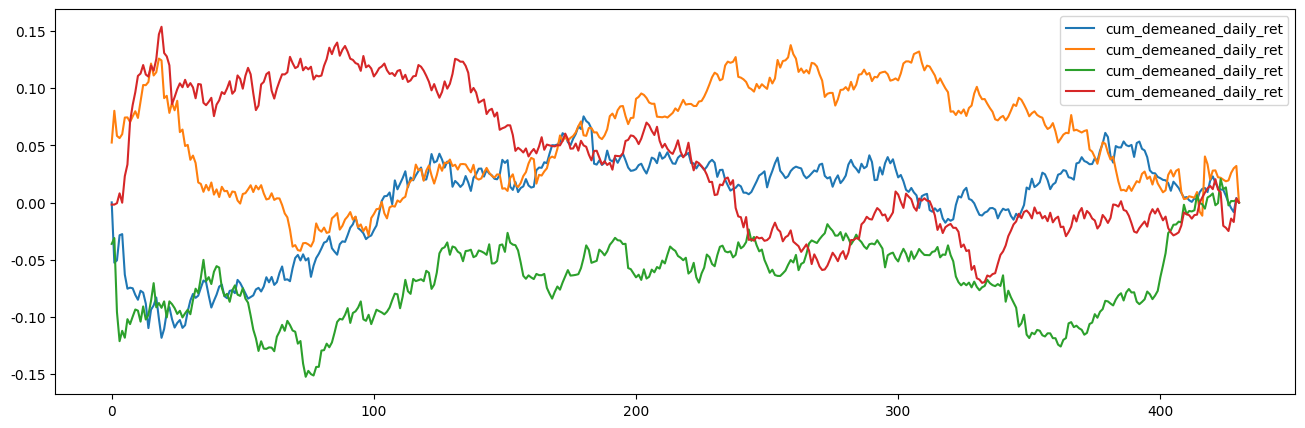

In [1582]:
ret_df[["cum_demeaned_daily_ret"]].plot(figsize = (16, 5))

# 週結算 target: wed

## read

In [1279]:
TX_df = pd.read_csv("TX.csv", index_col = "Timestamp")
TX_df.index = pd.to_datetime(TX_df.index)
TXa_df = pd.read_csv("TX_after.csv", index_col = "Timestamp")
TXa_df.index = pd.to_datetime(TXa_df.index)

## basic backtest

In [ ]:
""" init backtesting df"""

backtest_df = TX_df.copy()
backtest_df.index = pd.to_datetime(TX_df.index)

# indicator
first_open = backtest_df.groupby("weekly_group")["Open"].first()
settle_open = backtest_df.groupby("weekly_group")["Open"].last()
indicator = (settle_open / first_open) - 1
indicator.index = pd.to_datetime(indicator.index)
backtest_df["indicator"] = indicator

# calculate wed ret
backtest_df.loc[indicator.index, "wed_ret"] = (backtest_df.loc[indicator.index, "Close"] / backtest_df.loc[indicator.index, "Open"]) - 1

backtest_df.dropna(inplace = True)

In [1369]:
"""back test"""

backtest_df["ret"] = np.where(
    backtest_df["indicator"] > 0,
    backtest_df["wed_ret"],
    np.where(
        backtest_df["indicator"] < 0,
        - backtest_df["wed_ret"],
        0
    )
)

backtest_df["cum_ret"] = (1 + backtest_df["ret"]).cumprod() - 1

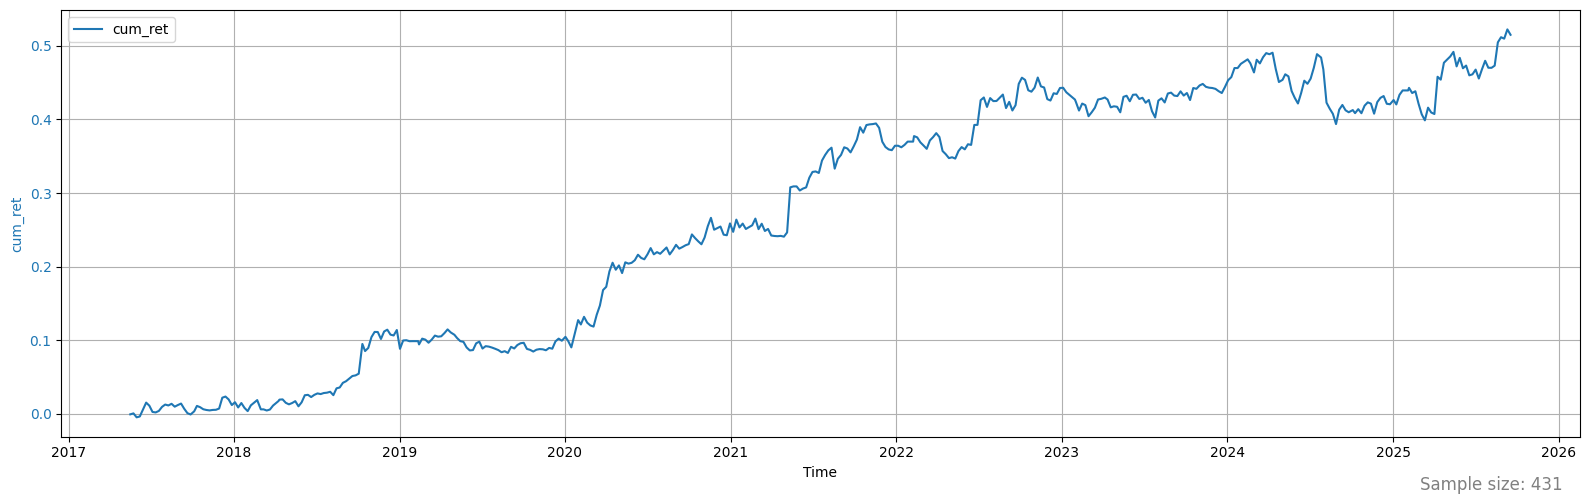

,淨利,總獲利,總虧損,最大獲利,最大虧損,勝次,敗次,無歸類,總次,勝均,敗均,筆均,EventRate,盈虧比,勝率,凱利,最大回撤
0,51.50%,136.83%,-94.02%,4.91%,-3.08%,231,193,7,431,0.59%,-0.49%,0.10%,98.38%,1.216,53.60%,15.43%,-6.51%


In [1378]:
plot(backtest_df, "cum_ret", "index")
get_performance(backtest_df, "ret")

## sum 跳空 ret

In [ ]:
operate_df = pd.DataFrame()

temp_df = TX_df.copy()
temp_df["cross_daily_ret"] = (temp_df["Open"] / temp_df["Close"].shift(1)) - 1


# t - 1 週 ret sumation
operate_df["sum_cross_ret"] = temp_df.groupby("weekly_group")["cross_daily_ret"].sum()

# t 週結算日報酬
operate_df["wed_ret"] = (temp_df["Close"] / temp_df["Open"]) - 1

# fill wed_ret NaN 順延下一個交易日
nan_idx = operate_df[operate_df["wed_ret"].isna()].index
for t in nan_idx:
    next_idx = temp_df.index[temp_df.index > t]
    next_date = next_idx[0] if len(next_idx) > 0 else None
    next_date = pd.to_datetime(next_date, format = "%Y-%m-%d") if next_date is not None else None
    ret = (temp_df.loc[next_date, "Close"] / temp_df.loc[next_date, "Open"]) - 1 if next_date is not None else np.nan
    operate_df.loc[t, "wed_ret"] = ret


# demeaning
mean = operate_df["wed_ret"].mean()
operate_df["demeaned_wed_ret"] = operate_df["wed_ret"] - mean
operate_df.to_csv("test.csv")

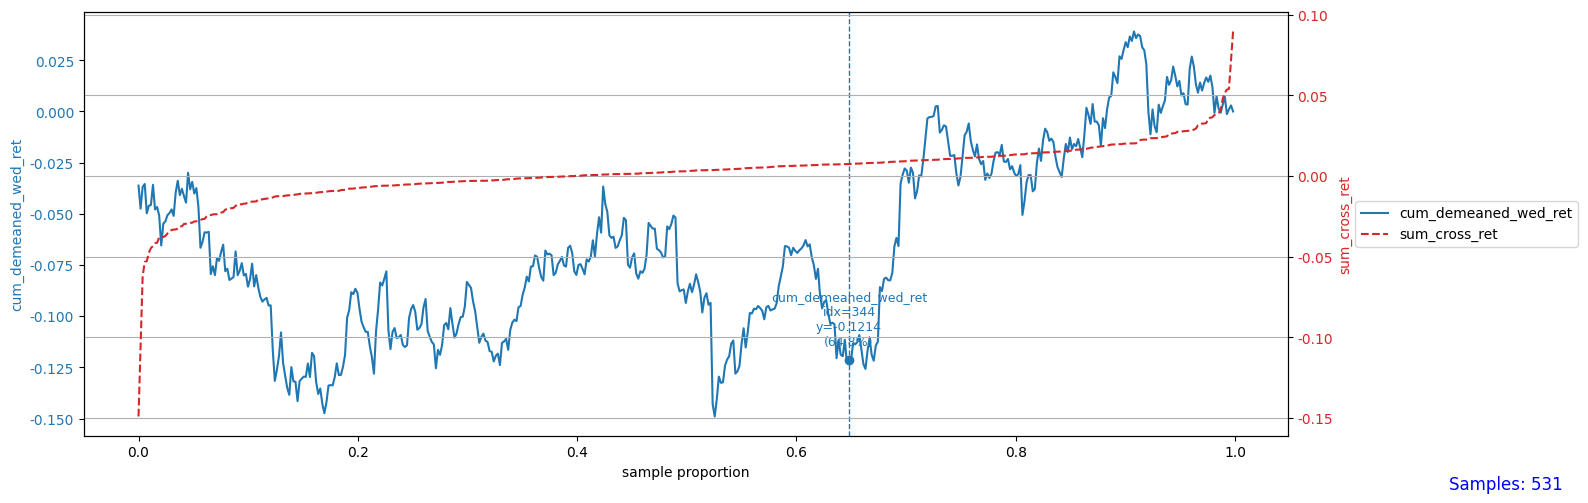

{'ly_max': None,
 'ly_point': {'index': 344,
  'rank': 345,
  'proportion': 0.647834274952919,
  'x': 0.647834274952919,
  'y': -0.12141591410463312},
 'ry_point': None}

In [491]:
"""sort & cumsum"""

operate_df.sort_values("sum_cross_ret", inplace = True)
operate_df.reset_index(drop = False, inplace = True)
operate_df["cum_demeaned_wed_ret"] = operate_df["demeaned_wed_ret"].cumsum()

sorted_plot(operate_df, "index", ly = "cum_demeaned_wed_ret", ry = "sum_cross_ret", point_ly_pct = 0.65)
# right idx: 344

In [492]:
"""seperate df & calculate mean"""
right_df = operate_df[344: ]
right_mean = right_df["demeaned_wed_ret"].mean()
print(f"right mean: {right_mean:.6f}")

right mean: 0.000657


## (filter) thu_open ~ wed_open, log +

In [1430]:
operate_df = pd.DataFrame()

temp_df = TX_df.copy()

# t - 1 週 ret
first_open = temp_df.groupby("weekly_group")["Open"].first()
settle_open = temp_df.groupby("weekly_group")["Open"].last()
operate_df["weekly_ret"] = (settle_open / first_open) - 1

# t 週結算日 ret
operate_df["wed_ret"] = (temp_df["Close"] / temp_df["Open"]) - 1

# demeaning
mean = operate_df["wed_ret"].mean()
operate_df["demeaned_wed_ret"] = operate_df["wed_ret"] - mean
operate_df.reset_index(drop = False, inplace = True)

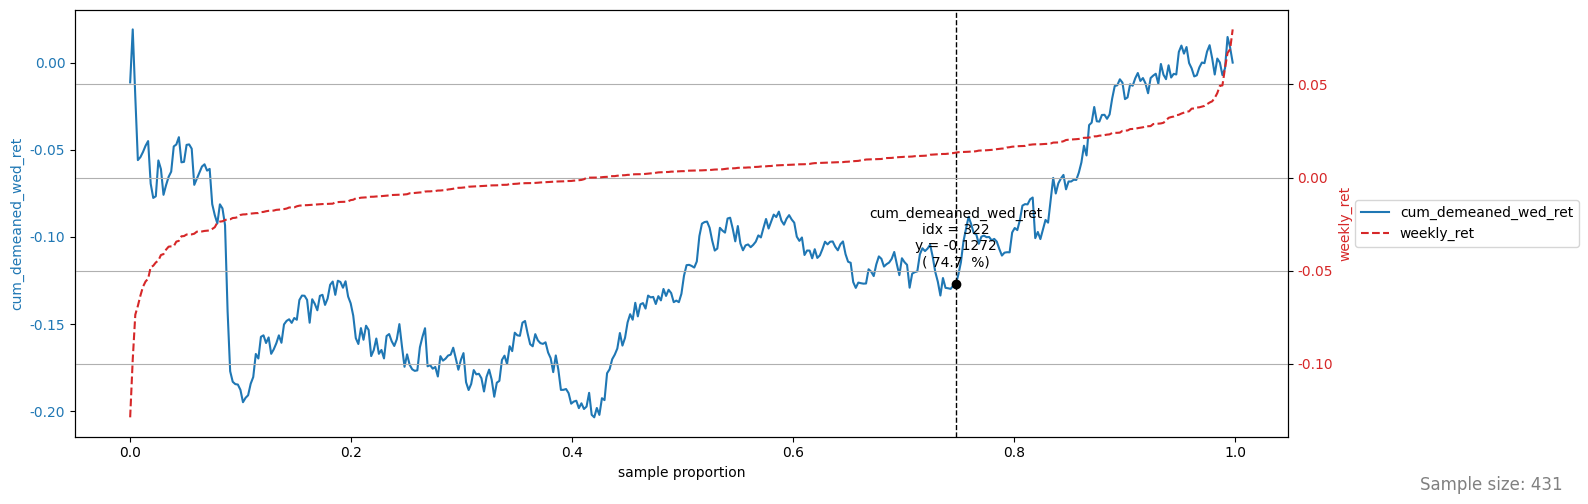

{'max_ly': None,
 'min_ly': None,
 'max_ry': None,
 'min_ry': None,
 'point_ly': {'index': 322,
  'rank': 323,
  'proportion': 0.7470997679814385,
  'x': 0.7470997679814385,
  'y': -0.12723977984519547},
 'point_ry': None}

In [1431]:
"""sort & cumsum"""

operate_df.sort_values("weekly_ret", inplace = True)
operate_df.reset_index(drop = True, inplace = True)
operate_df["cum_demeaned_wed_ret"] = operate_df["demeaned_wed_ret"].cumsum()

plot(operate_df, ly = "cum_demeaned_wed_ret", x = "index", ry = "weekly_ret", point_pct_ly = 0.75)
# 切點 idx: 172(0.4), 322(0.75)

left mean: -0.001103
middle mean: 0.000411
right mean: 0.001174


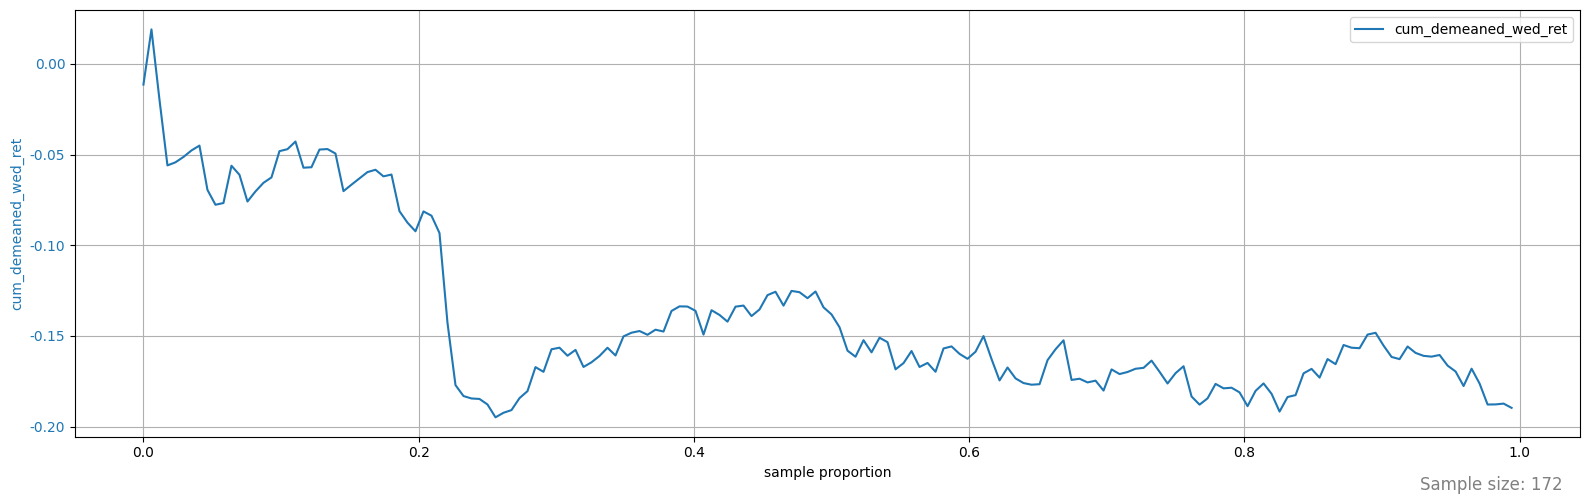

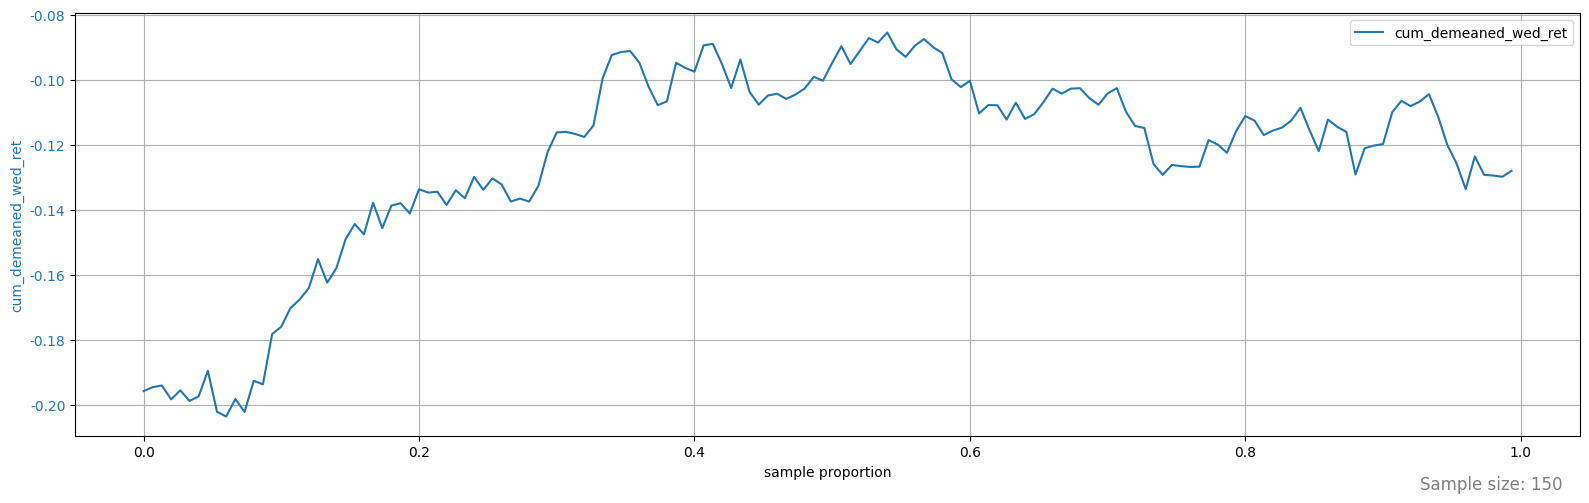

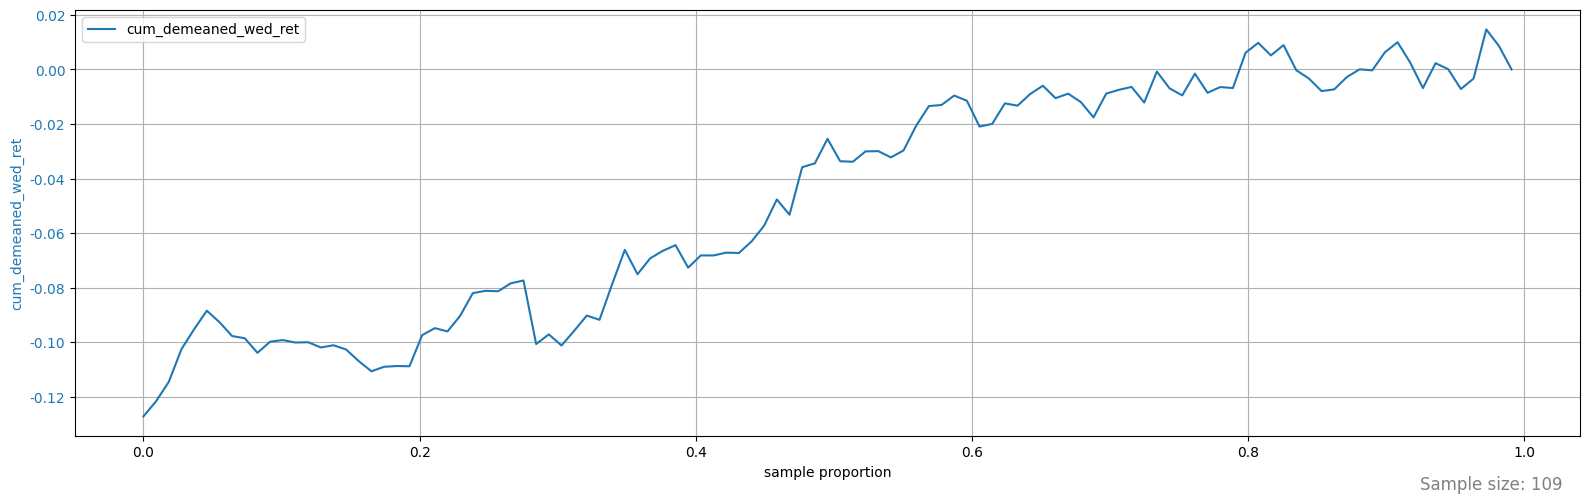

{'max_ly': None,
 'min_ly': None,
 'max_ry': None,
 'min_ry': None,
 'point_ly': None,
 'point_ry': None}

In [1432]:
# seperate df
left_df = operate_df[: 172]
middle_df = operate_df[172: 322]
right_df = operate_df[322: ]

# calculate mean
left_mean, middle_mean, right_mean = left_df["demeaned_wed_ret"].mean(), middle_df["demeaned_wed_ret"].mean(), right_df["demeaned_wed_ret"].mean()
print(f"left mean: {left_mean:.6f}\nmiddle mean: {middle_mean:.6f}\nright mean: {right_mean:.6f}")

plot(left_df, ly = "cum_demeaned_wed_ret", x = "index")
plot(middle_df, ly = "cum_demeaned_wed_ret", x = "index")
plot(right_df, ly = "cum_demeaned_wed_ret", x = "index")

In [1435]:
get_performance(left_df, "demeaned_wed_ret")
# get_performance(middle_df, "demeaned_wed_ret")
# get_performance(right_df, "demeaned_wed_ret")

,淨利,總獲利,總虧損,最大獲利,最大虧損,勝次,敗次,無歸類,總次,勝均,敗均,筆均,EventRate,盈虧比,勝率,凱利,最大回撤
0,-17.97%,47.54%,-66.51%,3.04%,-4.95%,88,84,0,172,0.54%,-0.79%,-0.11%,100.00%,0.682,51.16%,-20.41%,-19.66%


## (filter) 開高/低

In [915]:
operate_df = pd.DataFrame()
temp_df = TX_df.copy()

# get previous idx
all_idx = temp_df.index
target_idx = temp_df["weekly_group"].unique()
pos = np.searchsorted(all_idx, target_idx)
prev_idx = all_idx[pos - 1]

#calculate gap
gap = (temp_df.loc[target_idx, "Open"].to_numpy() / temp_df.loc[prev_idx, "Close"].to_numpy()) - 1
operate_df["gap"] = pd.Series(gap, index = target_idx)

# wed ret
operate_df["wed_ret"] = (temp_df.loc[target_idx, "Close"].to_numpy() / temp_df.loc[target_idx, "Open"].to_numpy()) - 1

# demeaning
mean = operate_df["wed_ret"].mean()
operate_df["demeaned_wed_ret"] = operate_df["wed_ret"] - mean
operate_df.reset_index(drop = False, inplace = True)

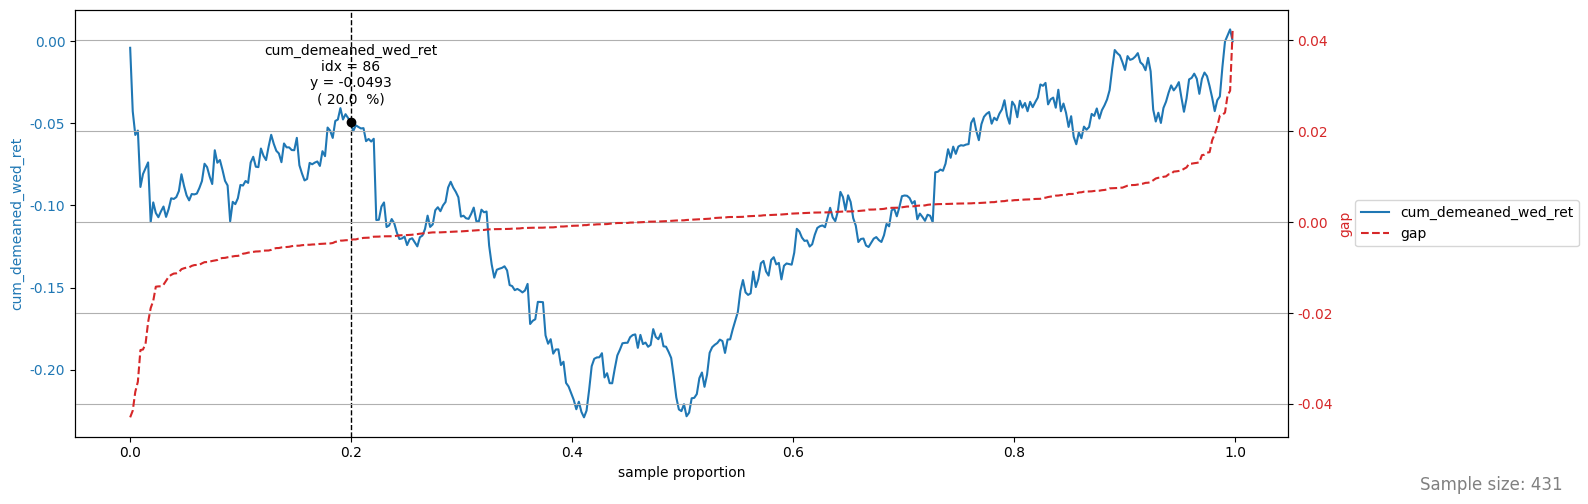

{'max_ly': None,
 'min_ly': None,
 'max_ry': None,
 'min_ry': None,
 'point_ly': {'index': 86,
  'rank': 87,
  'proportion': 0.19953596287703015,
  'x': 0.19953596287703015,
  'y': -0.04934013387178865},
 'point_ry': None}

In [866]:
"""sort & cumsum & plot"""

operate_df = operate_df.sort_values("gap").reset_index(drop = True)

# cumsum
operate_df["cum_demeaned_wed_ret"] = operate_df["demeaned_wed_ret"].cumsum()

# plot
plot(operate_df, ly = "cum_demeaned_wed_ret", x = "index", ry = "gap", point_pct_ly = 0.2)

left mean: -0.001902
right mean: 0.001038


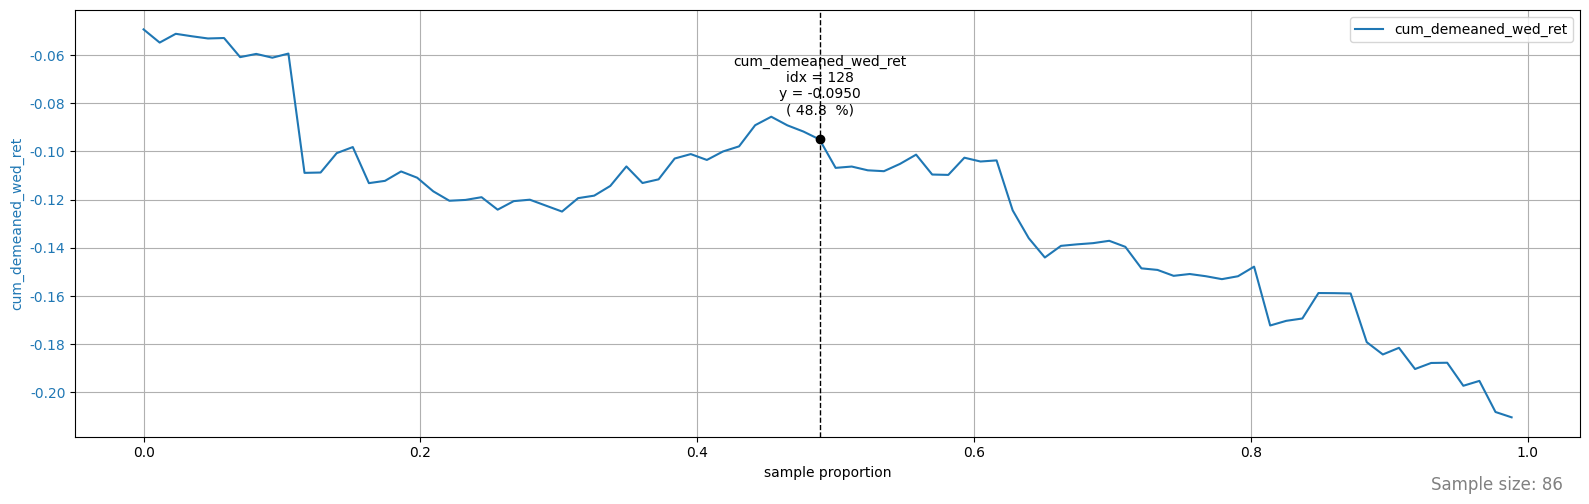

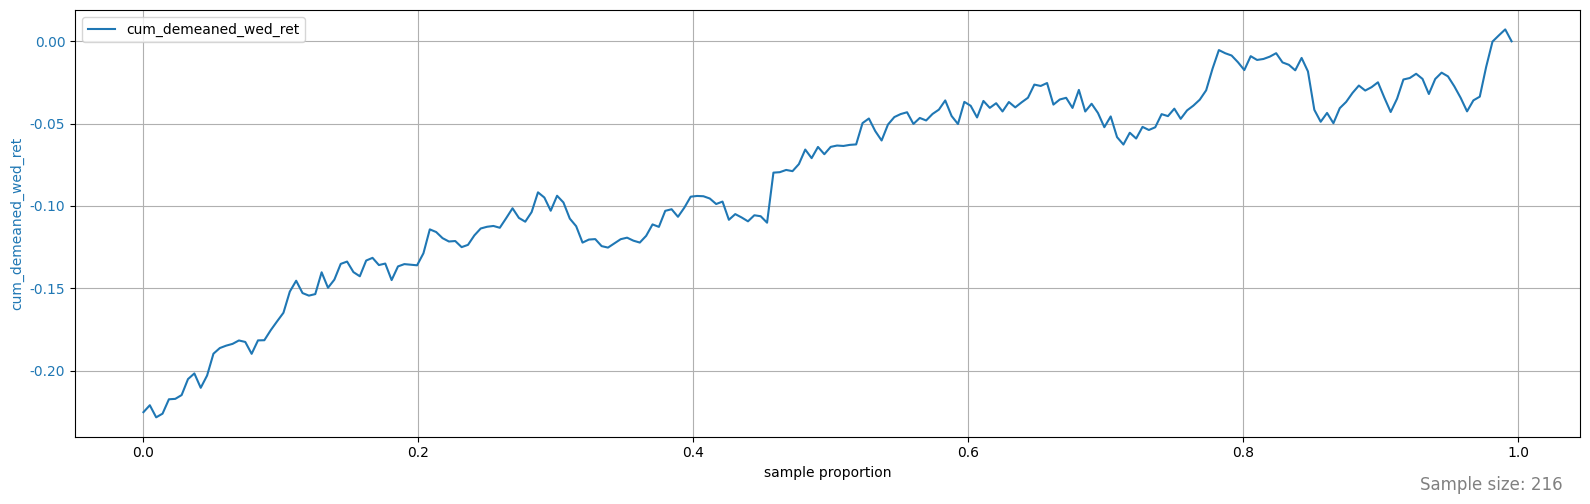

{'max_ly': None,
 'min_ly': None,
 'max_ry': None,
 'min_ry': None,
 'point_ly': None,
 'point_ry': None}

In [867]:
""" seperate df & calculate mean"""

# seperate
left_df = operate_df[86: 172]
right_df = operate_df[215: ]

# calculate mean
left_mean = left_df["demeaned_wed_ret"].mean()
right_mean = right_df["demeaned_wed_ret"].mean()
print(f"left mean: {left_mean:.6f}\nright mean: {right_mean:.6f}")

# plot
plot(left_df, ly = "cum_demeaned_wed_ret", x = "index", point_pct_ly = 0.5)
plot(right_df, ly = "cum_demeaned_wed_ret", x = "index")

### add filter 開高/低

In [824]:
# get previous idx
all_idx = temp_df.index
target_idx = operate_df["weekly_group"]
pos = np.searchsorted(all_idx, target_idx)
prev_idx = all_idx[pos - 1]

# calculate gap
gap = (temp_df["Open"].iloc[pos].values / temp_df["Close"].iloc[pos - 1].values) - 1
operate_df.sort_index(inplace = True, ignore_index = True)
operate_df["gap"] = gap

# resort operate
operate_df.sort_values("weekly_ret", inplace = True)

# seperate df
left_df = operate_df[: 172].copy()
middle_df = operate_df[172: 322].copy()
right_df = operate_df[322: ].copy()

# sort by gap
left_df = left_df.sort_values("gap").reset_index(drop = True)
middle_df = middle_df.sort_values("gap").reset_index(drop = True)
right_df = right_df.sort_values("gap").reset_index(drop = True)

# cumsum
left_df["cum_demeaned_wed_ret"] = left_df["demeaned_wed_ret"].cumsum()
middle_df["cum_demeaned_wed_ret"] = middle_df["demeaned_wed_ret"].cumsum()
right_df["cum_demeaned_wed_ret"] = right_df["demeaned_wed_ret"].cumsum()

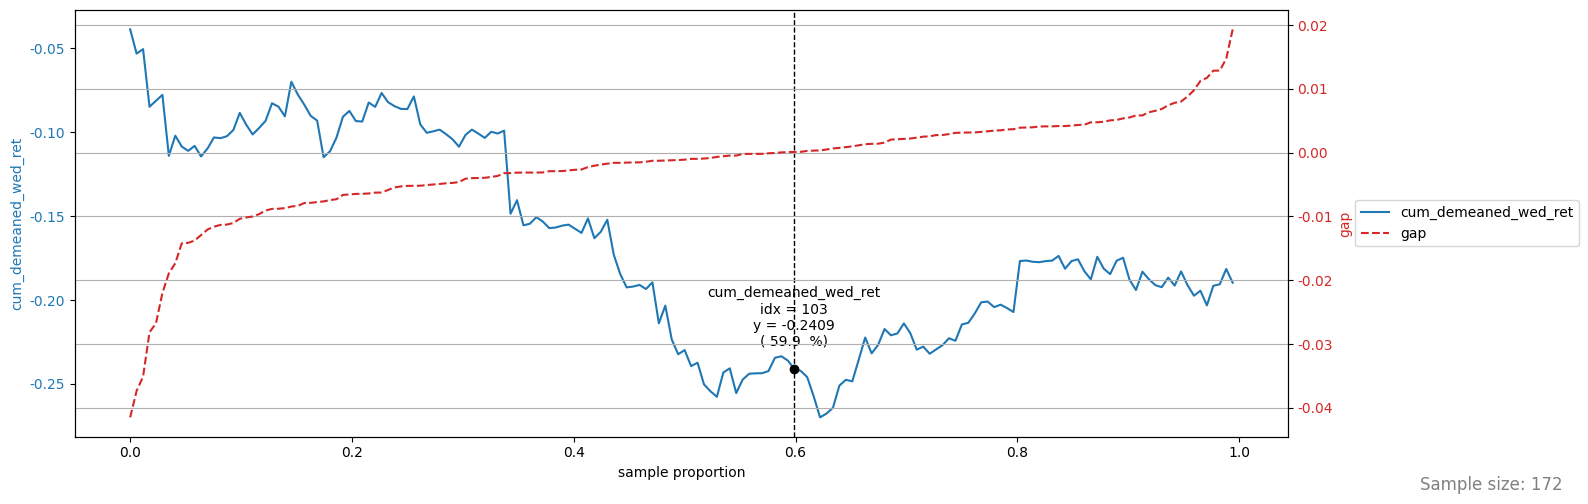

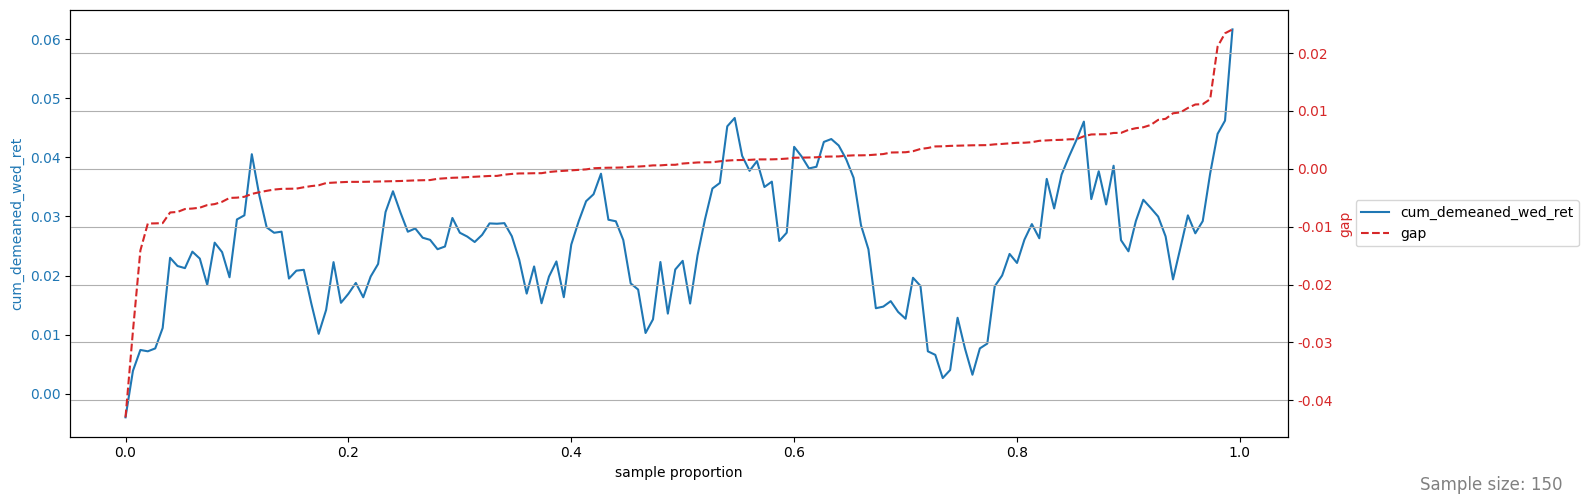

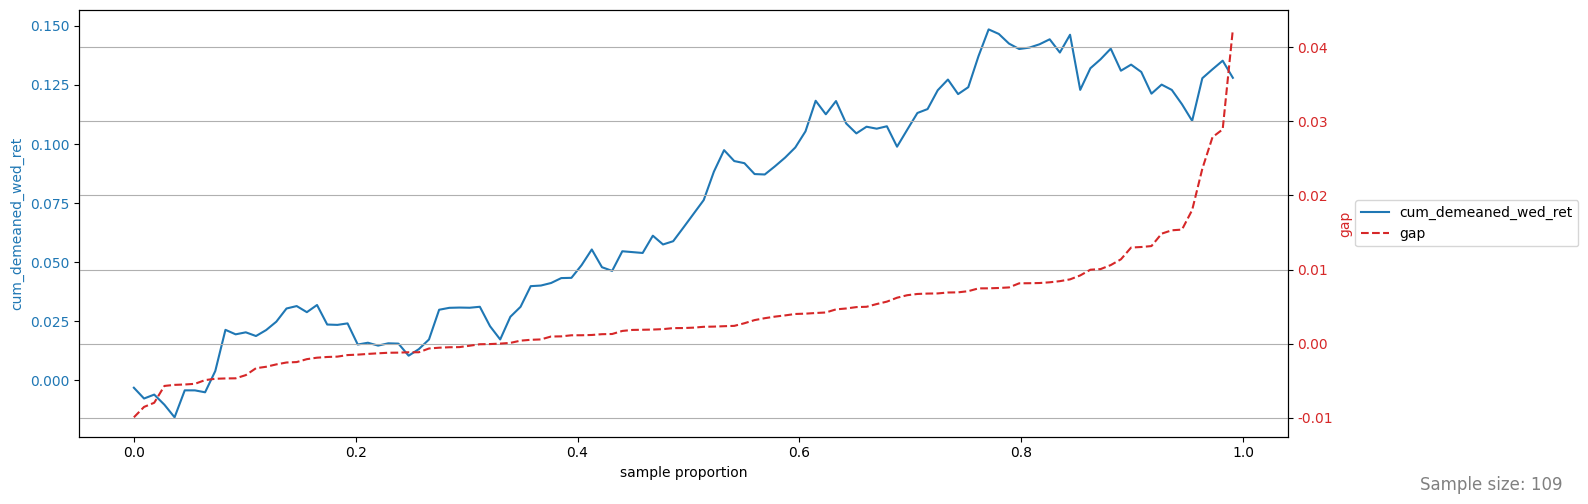

{'max_ly': None,
 'min_ly': None,
 'max_ry': None,
 'min_ry': None,
 'point_ly': None,
 'point_ry': None}

In [829]:
"""plot"""
plot(left_df, ly = "cum_demeaned_wed_ret", x = "index", ry = "gap", point_pct_ly = 0.6)
plot(middle_df, ly = "cum_demeaned_wed_ret", x = "index", ry = "gap")
plot(right_df, ly = "cum_demeaned_wed_ret", x = "index", ry = "gap")

# filter left_df, : 148
# filter right_df, all

In [832]:
filtered_left_df = left_df[: 103]
filtered_middle_df = middle_df
filtered_right_df = right_df

filtered_mean_left = filtered_left_df["demeaned_wed_ret"].mean()
filtered_mean_middle = filtered_middle_df["demeaned_wed_ret"].mean()
filtered_mean_right = filtered_right_df["demeaned_wed_ret"].mean()
print(f"filtered left mean: {filtered_mean_left:.6f}\nfiltered middle mean: {filtered_mean_middle:.6f}\nfiltered right mean: {filtered_mean_right:.6f}")

filtered left mean: -0.002292
filtered middle mean: 0.000411
filtered right mean: 0.001174


## (main) 開高/低：夜盤收盤 substitute 前一日盤收盤

### main filter

In [1461]:
operate_df = pd.DataFrame()
temp_df = TX_df.copy()
temp_a_df = TXa_df.copy()

temp_df.index = pd.to_datetime(temp_df.index)
temp_a_df.index = pd.to_datetime(temp_a_df.index)

# drop 調 group 太少的資料
temp_df = drop_small_groups(temp_df, "weekly_group", 2)
temp_a_df = drop_small_groups(temp_a_df, "weekly_group", 2)

# get idx
all_idx = temp_df.index
all_idx = all_idx.delete(all_idx.get_loc("2018-07-11"))  # 夜盤沒有 2018-07-11 資料
target_idx = temp_a_df["weekly_group"].unique()
pos = np.searchsorted(all_idx, target_idx)
prev_idx = all_idx[pos]

# calculate gap
gap = (temp_df.loc[target_idx, "Open"].to_numpy() / temp_a_df.loc[prev_idx, "Close"]) - 1
operate_df["gap"] = pd.Series(gap, index = target_idx)

# wed ret
operate_df["wed_ret"] = (temp_df.loc[target_idx, "Close"].to_numpy() / temp_df.loc[target_idx, "Open"].to_numpy()) - 1
operate_df.dropna(inplace = True)

# demeaning
mean = operate_df["wed_ret"].mean()
operate_df["demeaned_wed_ret"] = operate_df["wed_ret"] - mean
operate_df.reset_index(drop = False, inplace = True)

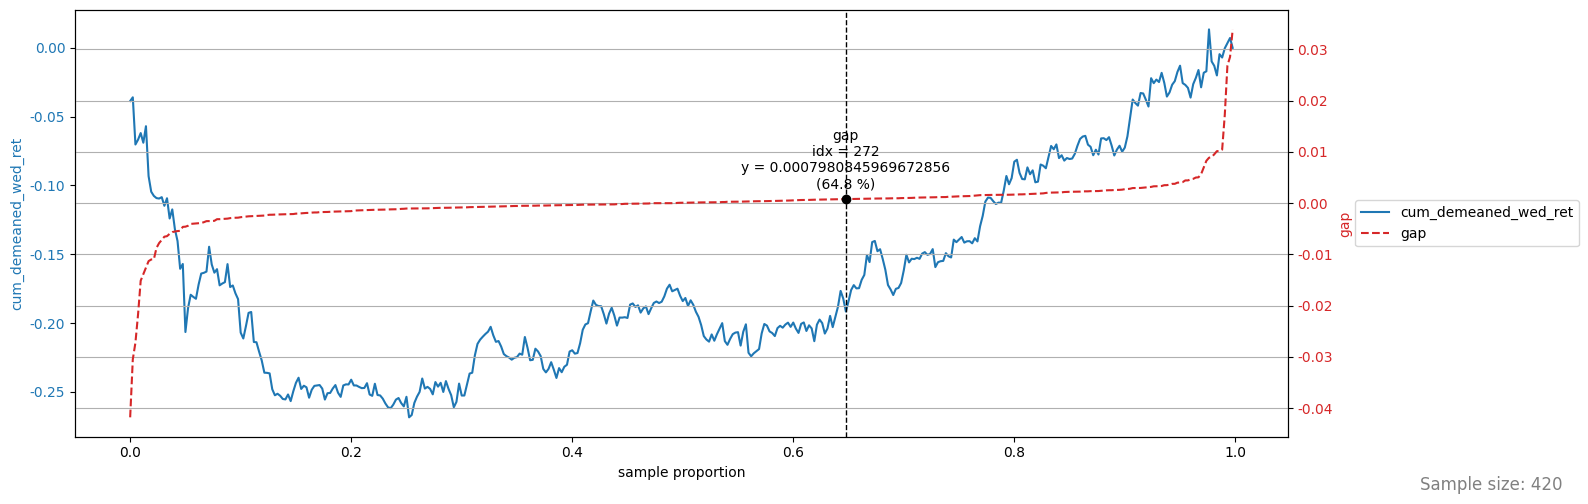

{'max_ly': None,
 'min_ly': None,
 'max_ry': None,
 'min_ry': None,
 'point_ly': None,
 'point_ry': {'index': 272,
  'rank': 273,
  'proportion': 0.6476190476190476,
  'x': 0.6476190476190476,
  'y': 0.0007980845969672856}}

In [1462]:
"""sort & cumsum & plot"""

operate_df = operate_df.sort_values("gap").reset_index(drop = True)
operate_df.to_csv("test.csv", index = False)
# cumsum
operate_df["cum_demeaned_wed_ret"] = operate_df["demeaned_wed_ret"].cumsum()

# plot
plot(operate_df, ly = "cum_demeaned_wed_ret", x = "index", ry = "gap", point_pct_ry = 0.65)
# 切點 idx: 51(0.15), 279(0.65)

In [1463]:
"""seperate & get metric"""
left_df = operate_df[: 51]
middle_df = operate_df[51: 279]
right_df = operate_df[279: ]

left_mean = left_df["demeaned_wed_ret"].mean()
middle_mean = middle_df["demeaned_wed_ret"].mean()
right_mean = right_df["demeaned_wed_ret"].mean()
print(f"left mean: {left_mean:.6f}\nmiddle mean: {middle_mean:.6f}\nright mean: {right_mean:.6f}")

# plot
# plot(left_df, ly = "cum_demeaned_wed_ret", x = "index")
# plot(middle_df, ly = "cum_demeaned_wed_ret", x = "index")
# plot(right_df, ly = "cum_demeaned_wed_ret", x = "index")

# performance
# get_performance(left_df, "demeaned_wed_ret")
# get_performance(middle_df, "demeaned_wed_ret")
get_performance(right_df, "demeaned_wed_ret")

left mean: -0.004455
middle mean: 0.000257
right mean: 0.001196


,淨利,總獲利,總虧損,最大獲利,最大虧損,勝次,敗次,無歸類,總次,勝均,敗均,筆均,EventRate,盈虧比,勝率,凱利,最大回撤
0,17.94%,45.99%,-29.13%,3.05%,-2.33%,80,61,0,141,0.57%,-0.48%,0.12%,100.00%,1.204,56.74%,20.80%,-3.87%


### add filter thu_open ~ wed_open, log +

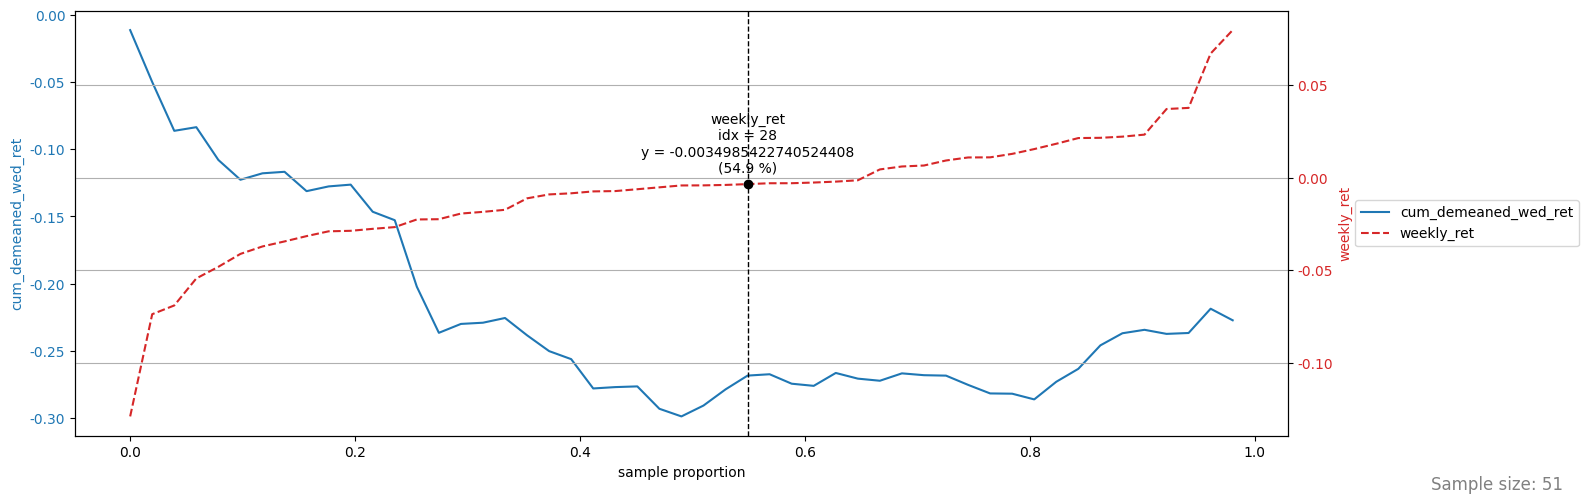

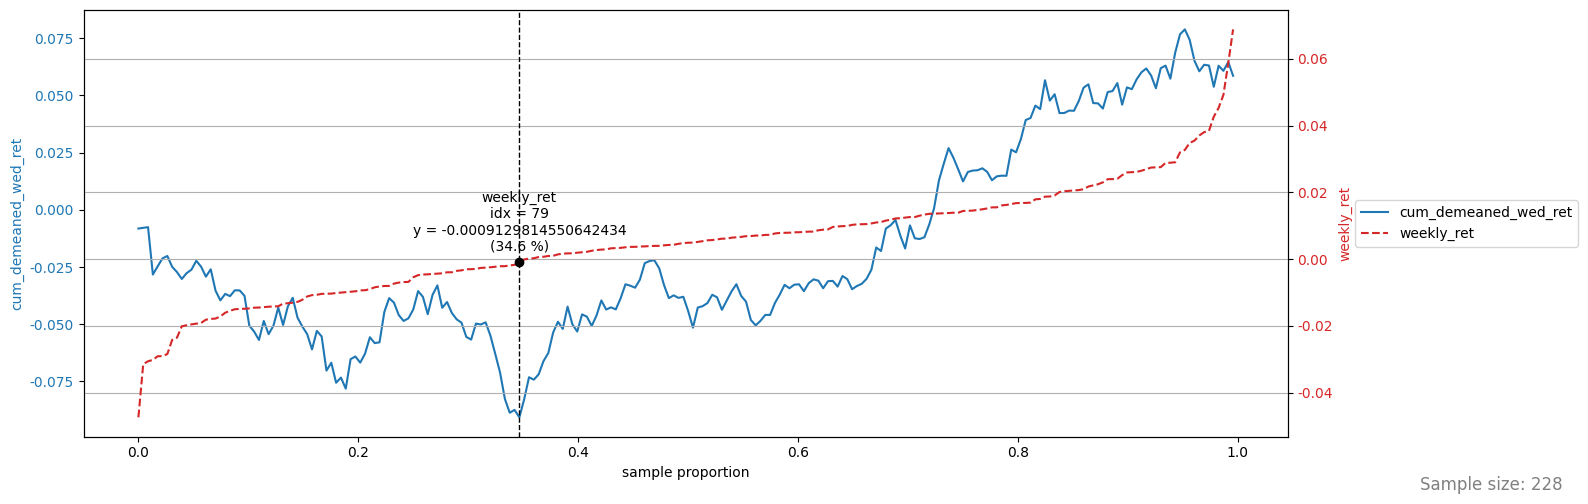

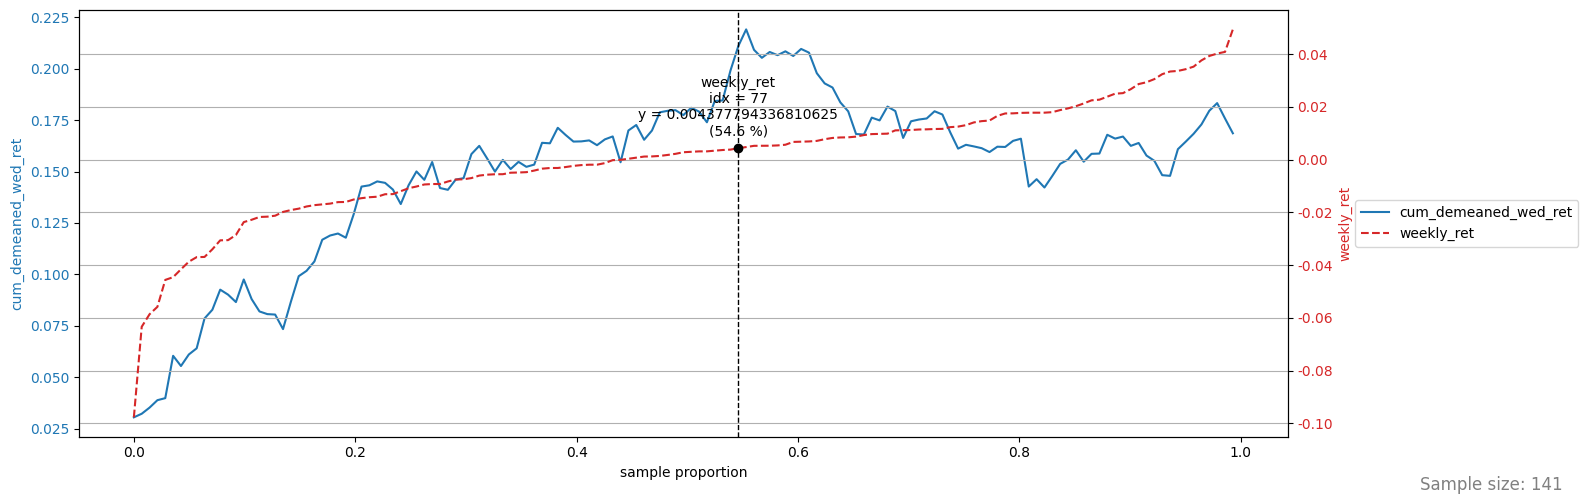

{'max_ly': None,
 'min_ly': None,
 'max_ry': None,
 'min_ry': None,
 'point_ly': None,
 'point_ry': {'index': 77,
  'rank': 78,
  'proportion': 0.5460992907801419,
  'x': 0.5460992907801419,
  'y': 0.004377794336810625}}

In [1464]:
operate_df.set_index("index", inplace = True)

# t - 1 月 ret
first_open = temp_df.groupby("weekly_group")["Open"].first()
settle_open = temp_df.groupby("weekly_group")["Open"].last()
operate_df["weekly_ret"] = (settle_open / first_open) - 1

# sort by gap
operate_df = operate_df.sort_values("gap").reset_index(drop = False)

# seperate df by gap
left_df = operate_df[: 51].copy()
middle_df = operate_df[51: 279].copy()
right_df = operate_df[279: ].copy()

# sort by weekly_ret
left_df = left_df.sort_values("weekly_ret").reset_index(drop = True)
middle_df = middle_df.sort_values("weekly_ret").reset_index(drop = True)
right_df = right_df.sort_values("weekly_ret").reset_index(drop = True)

# cumsum
left_df["cum_demeaned_wed_ret"] = left_df["demeaned_wed_ret"].cumsum()
middle_df["cum_demeaned_wed_ret"] = middle_df["demeaned_wed_ret"].cumsum()
right_df["cum_demeaned_wed_ret"] = right_df["demeaned_wed_ret"].cumsum()

# plot
plot(left_df, ly = "cum_demeaned_wed_ret", x = "index", ry = "weekly_ret", point_pct_ry = 0.55) # 0.55
plot(middle_df, ly = "cum_demeaned_wed_ret", x = "index", ry = "weekly_ret", point_pct_ry = 0.35) # 0.35
plot(right_df, ly = "cum_demeaned_wed_ret", x = "index", ry = "weekly_ret", point_pct_ry = 0.55) # 0.6

In [1468]:
ml_df

,index,gap,wed_ret,demeaned_wed_ret,cum_demeaned_wed_ret,weekly_ret
0,2018-02-07,-0.001977,-0.007830,-0.008159,-0.008159,-0.047362
1,2022-06-15,-0.000125,0.000623,0.000294,-0.007865,-0.031437
2,2022-12-21,-0.000492,0.000633,0.000304,-0.007561,-0.030564
3,2022-09-28,0.000363,-0.020368,-0.020697,-0.028258,-0.030158
4,2023-08-16,-0.002143,0.003926,0.003597,-0.024661,-0.029068
...,...,...,...,...,...,...
74,2021-09-08,-0.001722,-0.007646,-0.007975,-0.062943,-0.002237
75,2025-05-28,0.000748,-0.007843,-0.008172,-0.071115,-0.002096
76,2024-11-27,-0.002252,-0.011195,-0.011524,-0.082639,-0.002075
77,2024-03-20,0.000151,-0.005690,-0.006019,-0.088658,-0.001860


In [1465]:
"""seperate df & calculate mean"""
ll_df = left_df[: 28]
lr_df = left_df[28: ]
ml_df = middle_df[: 79]
mr_df = middle_df[79: ]
rl_df = right_df[: 90]
rr_df = right_df[90: ]

ll_mean = ll_df["demeaned_wed_ret"].mean()
lr_mean = lr_df["demeaned_wed_ret"].mean()
ml_mean = ml_df["demeaned_wed_ret"].mean()
mr_mean = mr_df["demeaned_wed_ret"].mean()
rl_mean = rl_df["demeaned_wed_ret"].mean()
rr_mean = rr_df["demeaned_wed_ret"].mean()
print(f"ll mean: {ll_mean:.6f}\nlr mean: {lr_mean:.6f}\nml mean: {ml_mean:.6f}\nmr mean: {mr_mean:.6f}\nrl mean: {rl_mean:.6f}\nrr mean: {rr_mean:.6f}")

ll mean: -0.009951
lr mean: 0.002235
ml mean: -0.001107
mr mean: 0.000980
rl mean: 0.002121
rr mean: -0.000436


In [1466]:
"""metric"""
# get_performance(ll_df, col = "demeaned_wed_ret")
# get_performance(lr_df, col = "demeaned_wed_ret")
get_performance(ml_df, col = "demeaned_wed_ret")
# get_performance(mr_df, col = "demeaned_wed_ret")
# get_performance(rl_df, col = "demeaned_wed_ret")
# get_performance(rr_df, col = "demeaned_wed_ret")

,淨利,總獲利,總虧損,最大獲利,最大虧損,勝次,敗次,無歸類,總次,勝均,敗均,筆均,EventRate,盈虧比,勝率,凱利,最大回撤
0,-8.51%,15.30%,-24.04%,1.33%,-2.07%,35,44,0,79,0.44%,-0.55%,-0.11%,100.00%,0.800,44.30%,-25.31%,-7.93%


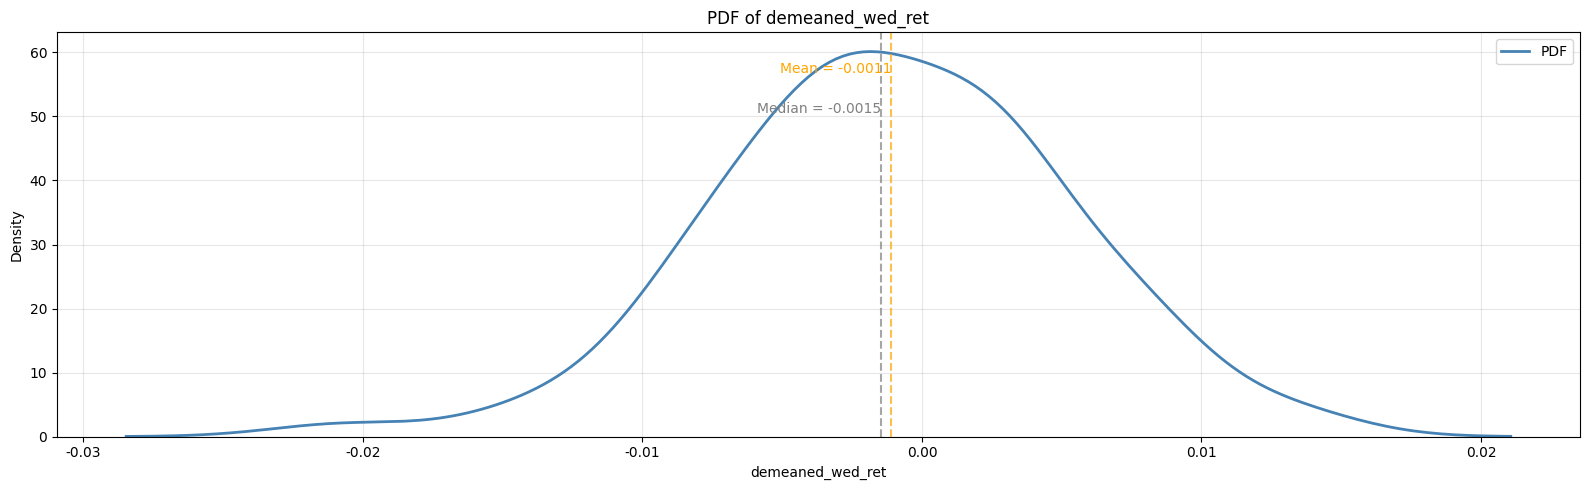

In [1467]:
"""plot pdf"""
# plot_pdf(ll_df, "demeaned_wed_ret")
# plot_pdf(lr_df, "demeaned_wed_ret")
plot_pdf(ml_df, "demeaned_wed_ret")
# plot_pdf(mr_df, "demeaned_wed_ret")
# plot_pdf(rl_df, "demeaned_wed_ret")
# plot_pdf(rr_df, "demeaned_wed_ret")

### backtest

In [1453]:
"""init backtesting df"""

backtest_df = TX_df.copy()
backtest_df.index = pd.to_datetime(TX_df.index)

# drop 掉 group 太少的資料
backtest_df = drop_small_groups(backtest_df, "weekly_group", 2)
temp_a_df = drop_small_groups(TXa_df, "weekly_group", 2)

# calculate gap
    # get idx
all_idx = backtest_df.index
all_idx = all_idx.delete(all_idx.get_loc("2018-07-11"))  # 夜盤沒有 2018-07-11 資料
target_idx = pd.to_datetime(temp_a_df["weekly_group"].unique())
pos = np.searchsorted(all_idx, target_idx)
prev_idx = all_idx[pos]

    # calculate gap
gap = (backtest_df.loc[target_idx, "Open"].to_numpy() / temp_a_df.loc[prev_idx, "Close"]) - 1
backtest_df.loc[target_idx, "gap"] = pd.Series(gap, index = target_idx)

# calculate thu_open ~ wed_open, log +
    # t - 1 週 ret
first_open = backtest_df.groupby("weekly_group")["Open"].first()
settle_open = backtest_df.groupby("weekly_group")["Open"].last()
weekly_ret = (settle_open / first_open) - 1
weekly_ret.index = pd.to_datetime(weekly_ret.index)
backtest_df.loc[weekly_ret.index, "weekly_ret"] = weekly_ret

# calculate wed ret
backtest_df.loc[target_idx, "wed_ret"] = (backtest_df.loc[target_idx, "Close"] / backtest_df.loc[target_idx, "Open"]) - 1
# backtest_df.loc[target_idx, "wed_ret"] = backtest_df.loc[target_idx, "wed_ret"] - 0.0001 # 扣 fee

# clean df
backtest_df.dropna(inplace = True)

In [1458]:
"""set condition"""
# 夜盤 gap
cond1 = backtest_df["gap"] <= -0.002143
cond2 = backtest_df["gap"] >= 0.000798

# thu_open ~ wed_open, log +
cond3 = backtest_df["weekly_ret"] <= -0.004183
cond4 = backtest_df["weekly_ret"] <= 0
cond5 = backtest_df["weekly_ret"] <= 0.006013

long_cond = (cond1 & ~cond3) | (~cond1 & ~cond2 & ~cond4) | (cond2 & cond5)
short_cond = (cond1 & cond3) | (~cond1 & ~cond2 & cond4) | (cond2 & ~cond5)

# long_cond = (cond1 & ~cond3) | (cond2 & cond5)
# short_cond = (cond1 & cond3) | (~cond1 & ~cond2 & cond4)

In [1459]:
# back test
backtest_df["ret"] = np.where(
    long_cond,
    backtest_df["wed_ret"],
    np.where(
        short_cond,
        - backtest_df["wed_ret"],
        0
    )
)

backtest_df["cum_ret"] = (1 + backtest_df["ret"]).cumprod() - 1

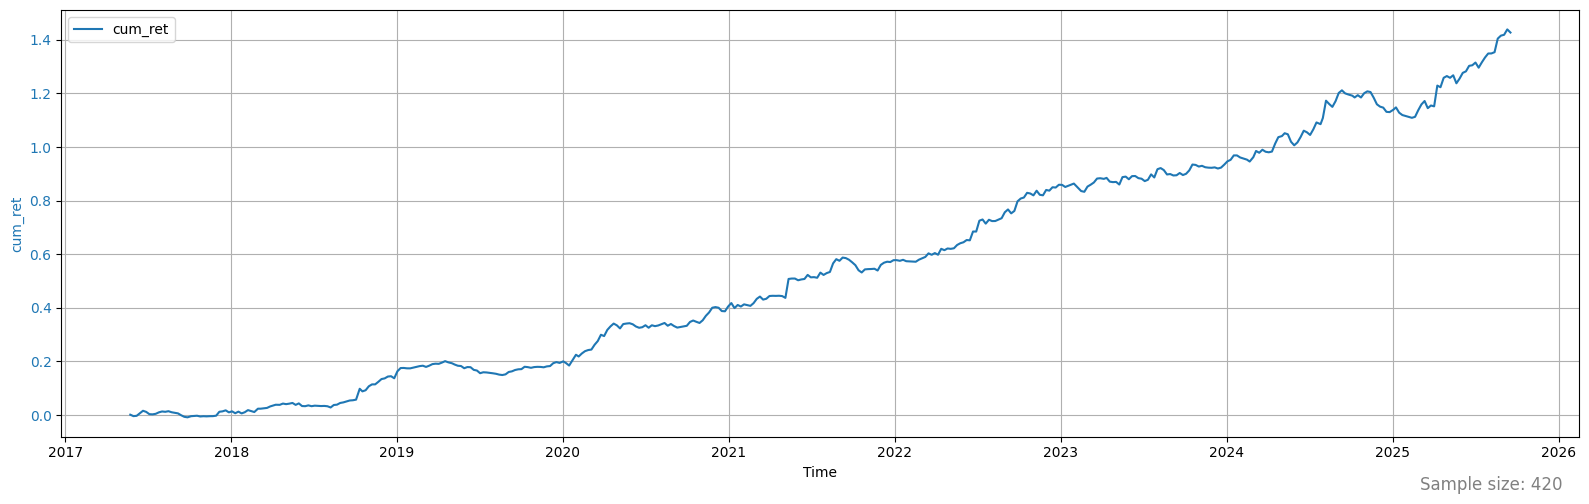

,淨利,總獲利,總虧損,最大獲利,最大虧損,勝次,敗次,無歸類,總次,勝均,敗均,筆均,EventRate,盈虧比,勝率,凱利,最大回撤
0,142.72%,159.15%,-69.22%,4.91%,-1.36%,246,170,4,420,0.65%,-0.41%,0.21%,99.05%,1.589,58.57%,32.50%,-4.64%


In [1460]:
plot(backtest_df, "cum_ret", "index")
performance = get_performance(backtest_df, "ret")
performance

# 月結算 target: wed

## read

In [1269]:
TX_df = pd.read_csv("TX.csv", index_col = "Timestamp")
TX_df.index = pd.to_datetime(TX_df.index, format = "%Y-%m-%d")

## sum 跳空 ret

In [1274]:
operate_df = pd.DataFrame()

temp_df = TX_df.copy()
temp_df["cross_daily_ret"] = (temp_df["Open"] / temp_df["Close"].shift(1)) - 1

# t - 1 月 ret sum
operate_df["sum_cross_ret"] = temp_df.groupby("monthly_group")["cross_daily_ret"].sum()

# t 週結算日 ret
operate_df["wed_ret"] = (temp_df["Close"] / temp_df["Open"]) - 1

# fill wed_ret NaN 順延下一個交易日
nan_idx = operate_df[operate_df["wed_ret"].isna()].index
for t in nan_idx:
    next_idx = temp_df.index[temp_df.index > t]
    next_date = next_idx[0] if len(next_idx) > 0 else None
    next_date = pd.to_datetime(next_date, format = "%Y-%m-%d") if next_date is not None else None
    ret = (temp_df.loc[next_date, "Close"] / temp_df.loc[next_date, "Open"]) - 1 if next_date is not None else np.nan
    operate_df.loc[t, "wed_ret"] = ret

# demeaning
mean = operate_df["wed_ret"].mean()
operate_df["demeaned_wed_ret"] = operate_df["wed_ret"] - mean
operate_df.to_csv("test.csv")

In [1275]:
"""sort & cumsum"""

operate_df.sort_values("sum_cross_ret", inplace = True)
operate_df.reset_index(drop = False, inplace = True)
operate_df["cum_demeaned_wed_ret"] = operate_df["demeaned_wed_ret"].cumsum()
operate_df

,monthly_group,sum_cross_ret,wed_ret,demeaned_wed_ret,cum_demeaned_wed_ret
0,2020-03-18,-0.190440,-0.010997,-0.010648,-1.064800e-02
1,2025-04-16,-0.071927,-0.002704,-0.002355,-1.300273e-02
2,2025-03-19,-0.071098,-0.012321,-0.011972,-2.497476e-02
3,2019-08-21,-0.067328,0.001332,0.001681,-2.329398e-02
4,2022-09-21,-0.065756,-0.005112,-0.004763,-2.805667e-02
...,...,...,...,...,...
96,2025-09-17,0.071574,-0.004813,-0.004464,8.211914e-03
97,2023-01-30,0.074094,-0.006877,-0.006528,1.683644e-03
98,2022-11-16,0.087433,-0.008276,-0.007927,-6.243469e-03
99,2020-08-19,0.089460,-0.007671,-0.007322,-1.356569e-02


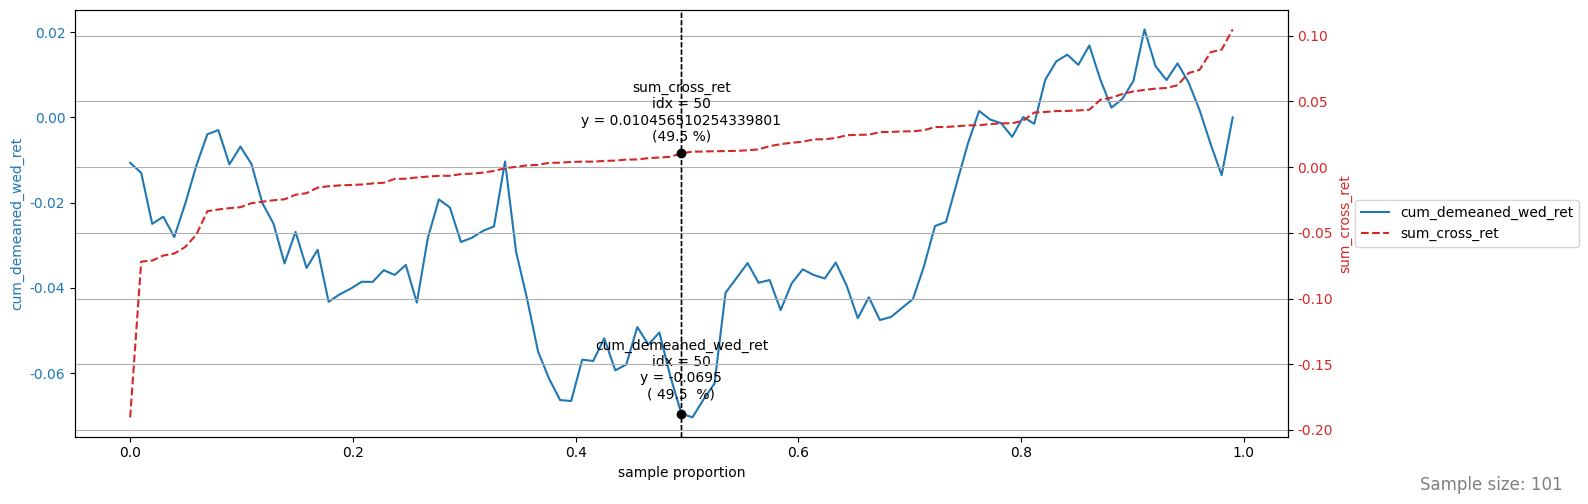

{'max_ly': None,
 'min_ly': None,
 'max_ry': None,
 'min_ry': None,
 'point_ly': {'index': 50,
  'rank': 51,
  'proportion': 0.49504950495049505,
  'x': 0.49504950495049505,
  'y': -0.06950575989940225},
 'point_ry': {'index': 50,
  'rank': 51,
  'proportion': 0.49504950495049505,
  'x': 0.49504950495049505,
  'y': 0.010456510254339801}}

In [1276]:
plot(operate_df, x = "index", ly = "cum_demeaned_wed_ret", ry = "sum_cross_ret", point_pct_ly = 0.5, point_pct_ry = 0.5)

In [1278]:
a = operate_df.loc[50: ]
mean_a = a["demeaned_wed_ret"].mean()
print(mean_a)

0.001192357227187985


## thu_open ~ wed_open log +

In [1143]:
operate_df = pd.DataFrame()

temp_df = TX_df.copy()

# t - 1 月 ret
first_open = temp_df.groupby("monthly_group")["Open"].first()
settle_open = temp_df.groupby("monthly_group")["Open"].last()
operate_df["monthly_ret"] = (settle_open / first_open) - 1

# t 週結算日 ret
operate_df["wed_ret"] = (temp_df["Close"] / temp_df["Open"]) - 1

# fill wed_ret NaN 順延下一個交易日
nan_idx = operate_df[operate_df["wed_ret"].isna()].index
for t in nan_idx:
    next_idx = temp_df.index[temp_df.index > t]
    next_date = next_idx[0] if len(next_idx) > 0 else None
    next_date = pd.to_datetime(next_date, format = "%Y-%m-%d") if next_date is not None else None
    ret = (temp_df.loc[next_date, "Close"] / temp_df.loc[next_date, "Open"]) - 1 if next_date is not None else np.nan
    operate_df.loc[t, "wed_ret"] = ret

# demeaning
mean = operate_df["wed_ret"].mean()
operate_df["demeaned_wed_ret"] = operate_df["wed_ret"] - mean

filtered_df = operate_df.copy()

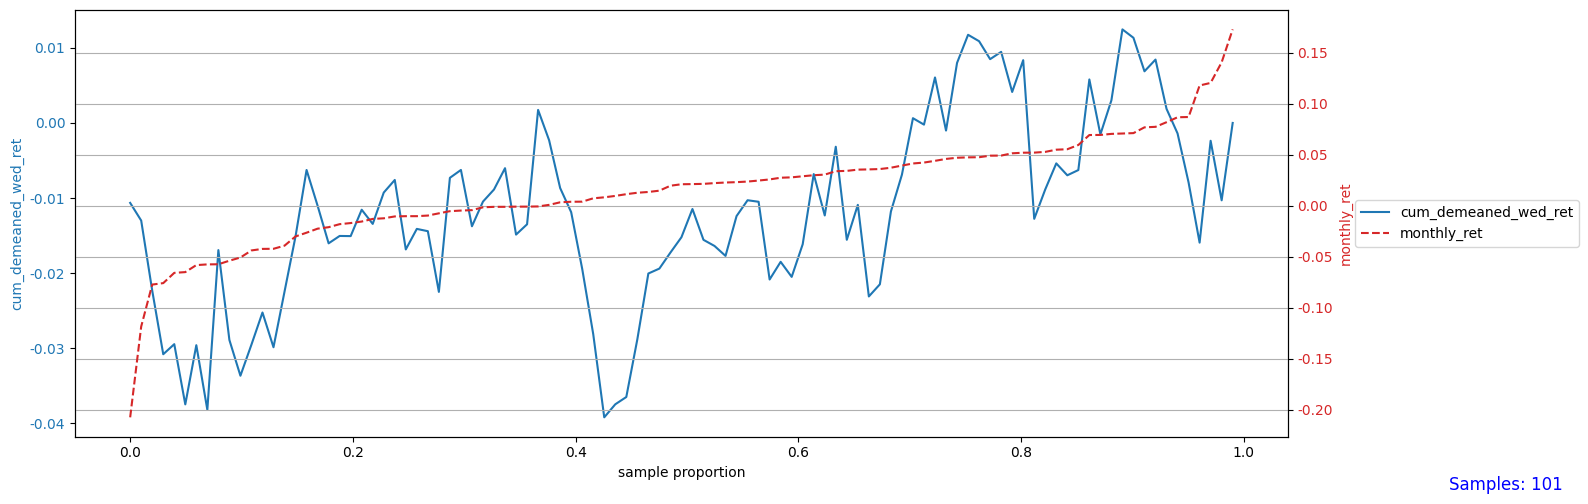

{'ly_max': None, 'ly_point': None, 'ry_point': None}

In [1145]:
"""sort & cumsum & plot"""

operate_df.sort_values("monthly_ret", inplace = True)
operate_df.reset_index(drop = False, inplace = True)
operate_df["cum_demeaned_wed_ret"] = operate_df["demeaned_wed_ret"].cumsum()

plot(operate_df, x = "index", ly = "cum_demeaned_wed_ret", ry = "monthly_ret")

In [835]:
"""seperate df & calculate mean"""
right_df = operate_df[58: ].copy()
right_mean = right_df["demeaned_wed_ret"].mean()

print(f"right mean: {right_mean:.6f}")

right mean: 0.000244


### add filter 跳空

In [582]:
# get previous idx
all_idx = temp_df.index
target_idx = filtered_df.index
pos = np.searchsorted(all_idx, target_idx)
prev_idx = all_idx[pos - 1]

# calculate gap
gap = (temp_df["Open"].iloc[pos].values / temp_df["Close"].iloc[pos - 1].values) - 1
filtered_df["gap"] = gap

# split df
filtered_df.sort_values("monthly_ret", inplace = True)
right_df = filtered_df[58: ].copy()

# sort by gap
right_df = right_df.sort_values("gap").reset_index(drop = False)

# cumsum
right_df["cum_demeaned_wed_ret"] = right_df["demeaned_wed_ret"].cumsum()

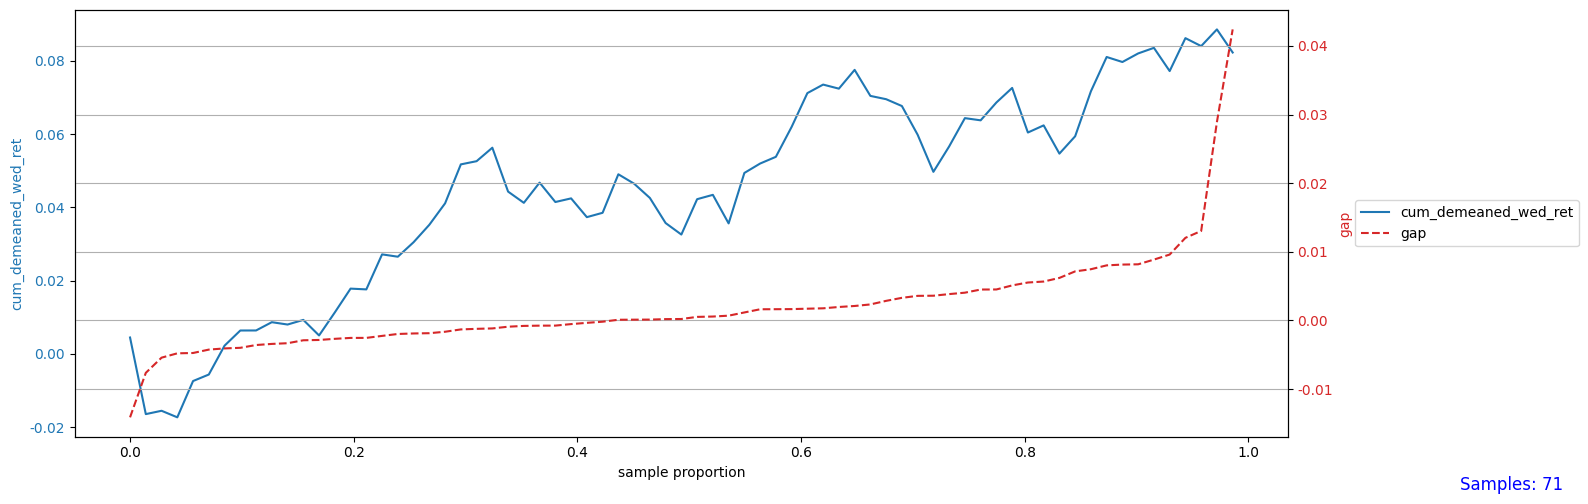

{'ly_max': None, 'ly_point': None, 'ry_point': None}

In [583]:
"""plot"""
sorted_plot(right_df, "index", ly = "cum_demeaned_wed_ret", ry = "gap")

# 週結算 target: thu

## read

In [1241]:
TX_df = pd.read_csv("TX.csv", index_col = "Timestamp")
TX_df.index = pd.to_datetime(TX_df.index, format = "%Y-%m-%d")

## sum t - 1 週 ret, target: thu ret

In [1255]:
operate_df = pd.DataFrame()

# 算 ret
temp_df = TX_df.copy()
temp_df["daily_ret"] = (temp_df["Close"] / temp_df["Open"]) - 1

# t - 1 週報酬
operate_df["sum_ret"] = temp_df.groupby("weekly_group")["daily_ret"].sum().rename("sum_ret")
operate_df = operate_df[: -1]
operate_df.index = pd.to_datetime(operate_df.index, format = "%Y-%m-%d")

# get thu index
all_date = temp_df.index
settle_date = list(temp_df["weekly_group"].unique())
target_pos = all_date.searchsorted(settle_date, side = "right")
target_pos = target_pos[: -1]

# t 週第一跟根報酬
thu_ret = (temp_df["Close"].iloc[target_pos] / temp_df["Open"].iloc[target_pos]) - 1
operate_df["thu_ret"] = thu_ret.values

# demeaning
mean = operate_df["thu_ret"].mean()
operate_df["demeaned_thu_ret"] = operate_df["thu_ret"] - mean
operate_df

,sum_ret,thu_ret,demeaned_thu_ret
weekly_group,,,
2017-05-17,-0.001092,0.004847,0.005043
2017-05-24,0.004540,0.006473,0.006669
2017-05-31,-0.002534,0.003888,0.004084
2017-06-07,0.012273,0.000686,0.000882
2017-06-14,-0.011982,0.002189,0.002385
...,...,...,...
2025-08-13,0.017422,-0.003575,-0.003379
2025-08-20,-0.016003,0.005184,0.005379
2025-08-27,0.014493,-0.005337,-0.005141


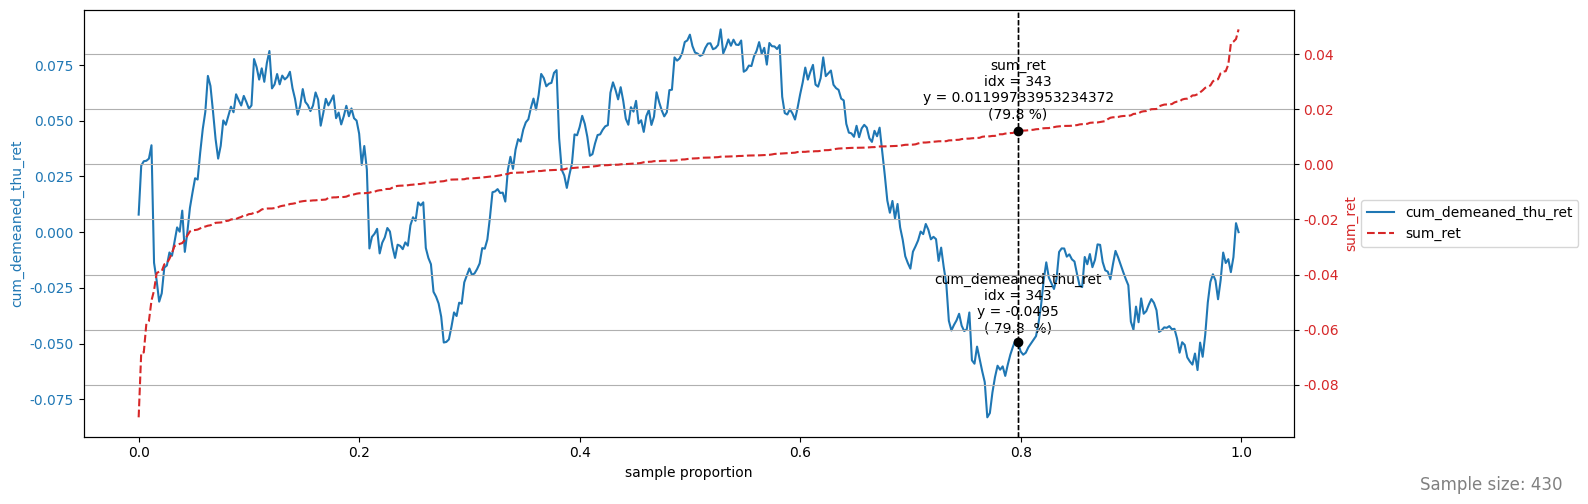

{'max_ly': None,
 'min_ly': None,
 'max_ry': None,
 'min_ry': None,
 'point_ly': {'index': 343,
  'rank': 344,
  'proportion': 0.7976744186046512,
  'x': 0.7976744186046512,
  'y': -0.04949187760846915},
 'point_ry': {'index': 343,
  'rank': 344,
  'proportion': 0.7976744186046512,
  'x': 0.7976744186046512,
  'y': 0.01199733953234372}}

In [1258]:
"""sort, cumsum & plot"""
operate_df.sort_values("sum_ret", inplace = True)
operate_df.reset_index(drop = False, inplace = True)
operate_df["cum_demeaned_thu_ret"] = operate_df["demeaned_thu_ret"].cumsum()

plot(operate_df, x = "index", ly = "cum_demeaned_thu_ret", ry = "sum_ret", point_pct_ly = 0.8, point_pct_ry = 0.8)

In [1257]:
a = operate_df.loc[214: 343].copy()
mean_a = a["demeaned_thu_ret"].mean()
print(mean_a)

-0.0010371785997030267


## sum 跳空

In [1264]:
operate_df = pd.DataFrame()

temp_df = TX_df.copy()
temp_df["cross_daily_ret"] = (temp_df["Open"].shift(-1) / temp_df["Close"]) - 1

# t - 1 週 ret sumation
operate_df["sum_cross_ret"] = temp_df.groupby("weekly_group")["cross_daily_ret"].sum()
operate_df = operate_df[: -1]

# 抓到結算隔天的idx
all_date = temp_df.index
settle_date = list(temp_df["weekly_group"].unique())
target_pos = all_date.searchsorted(settle_date, side = "right")
target_pos = target_pos[: -1]

# get target ret
thu_ret = (temp_df["Close"].iloc[target_pos] / temp_df["Open"].iloc[target_pos]) - 1
operate_df["thu_ret"] = thu_ret.values

# demeaning
mean = operate_df["thu_ret"].mean()
operate_df["demeaned_thu_ret"] = operate_df["thu_ret"] - mean
operate_df

,sum_cross_ret,thu_ret,demeaned_thu_ret
weekly_group,,,
2017-05-17,-0.012594,0.004847,0.005043
2017-05-24,0.009430,0.006473,0.006669
2017-05-31,0.001383,0.003888,0.004084
2017-06-07,0.004962,0.000686,0.000882
2017-06-14,-0.003048,0.002189,0.002385
...,...,...,...
2025-08-13,0.010973,-0.003575,-0.003379
2025-08-20,-0.008960,0.005184,0.005379
2025-08-27,0.011881,-0.005337,-0.005141


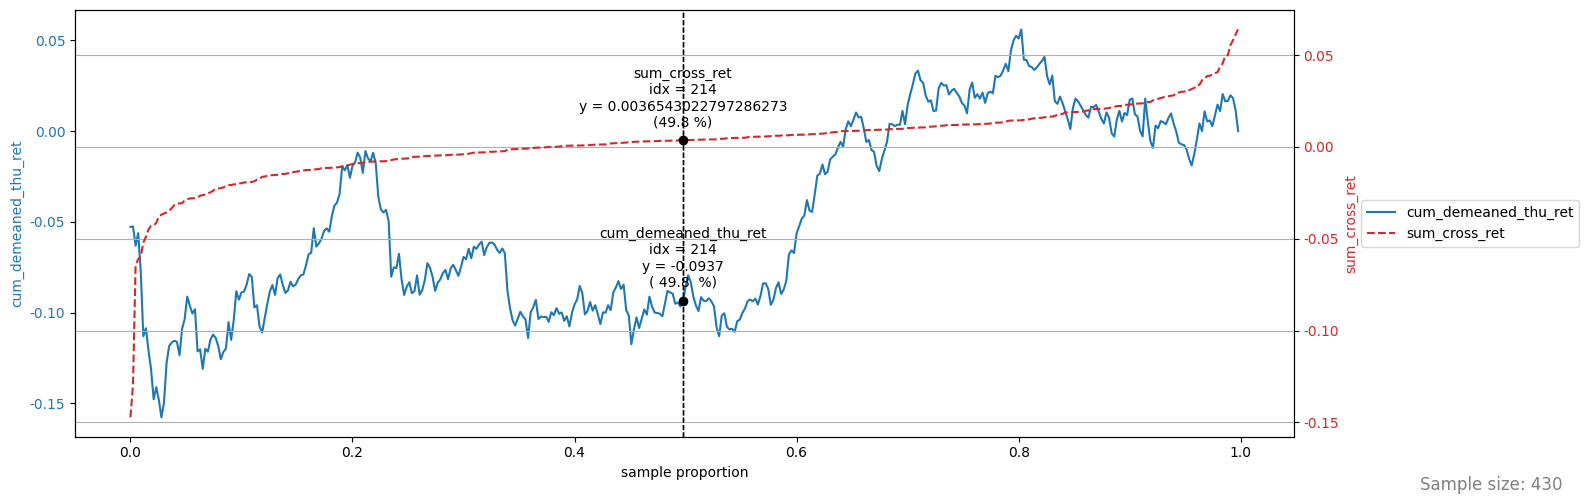

{'max_ly': None,
 'min_ly': None,
 'max_ry': None,
 'min_ry': None,
 'point_ly': {'index': 214,
  'rank': 215,
  'proportion': 0.49767441860465117,
  'x': 0.49767441860465117,
  'y': -0.09369325378200191},
 'point_ry': {'index': 214,
  'rank': 215,
  'proportion': 0.49767441860465117,
  'x': 0.49767441860465117,
  'y': 0.0036543022797286273}}

In [1266]:
"""sort & cumsum & plot"""

operate_df.sort_values("sum_cross_ret", inplace = True)
operate_df.reset_index(drop = False, inplace = True)
operate_df["cum_demeaned_thu_ret"] = operate_df["demeaned_thu_ret"].cumsum()

plot(operate_df, x = "index", ly = "cum_demeaned_thu_ret", ry = "sum_cross_ret", point_pct_ly = 0.5, point_pct_ry = 0.5)

In [1268]:
a = operate_df.loc[214: 343]
mean_a = a["demeaned_thu_ret"].mean()
print(mean_a)

0.0011476839451504495


# Others

## 台指期日報酬pdf

### read

In [1415]:
TX_df = pd.read_csv("TX.csv")
TX_df.set_index("Timestamp", inplace = True)
TX_df.index = pd.to_datetime(TX_df.index)

TXa_df = pd.read_csv("TX_after.csv")
TXa_df.set_index("Timestamp", inplace = True)
TXa_df.index = pd.to_datetime(TXa_df.index)

### draw pdf

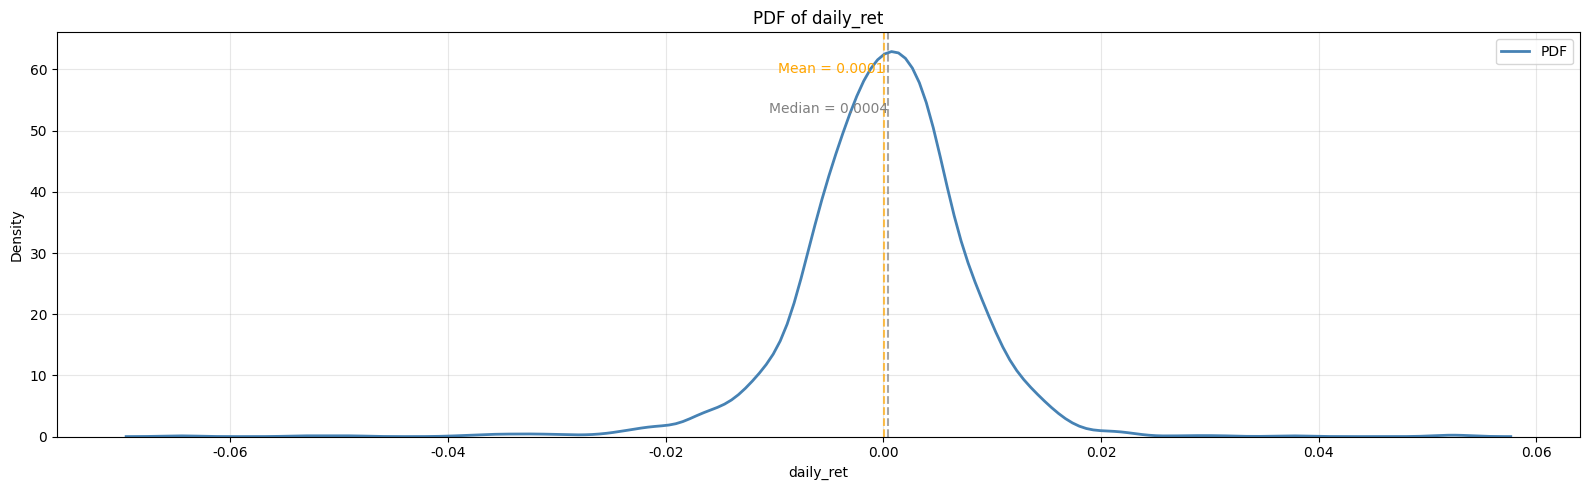

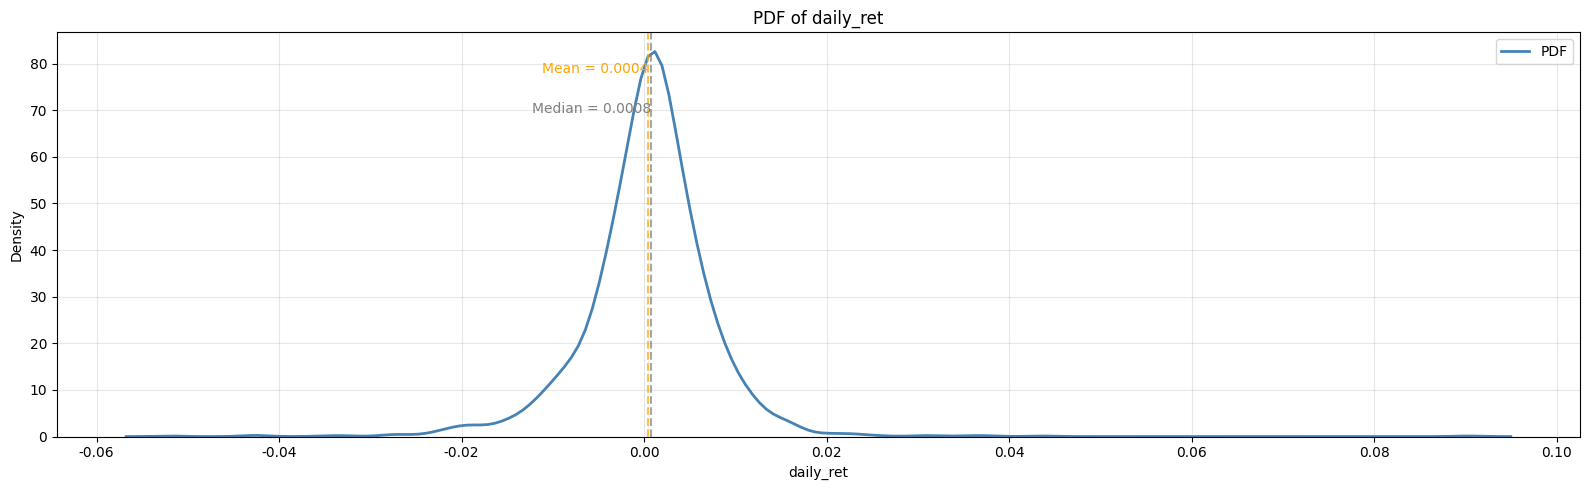

In [1416]:
TX_df["daily_ret"] = (TX_df["Close"] / TX_df["Open"]) - 1
TXa_df["daily_ret"] = (TXa_df["Close"] / TXa_df["Open"]) - 1
plot_pdf(TX_df, "daily_ret")
plot_pdf(TXa_df, "daily_ret")

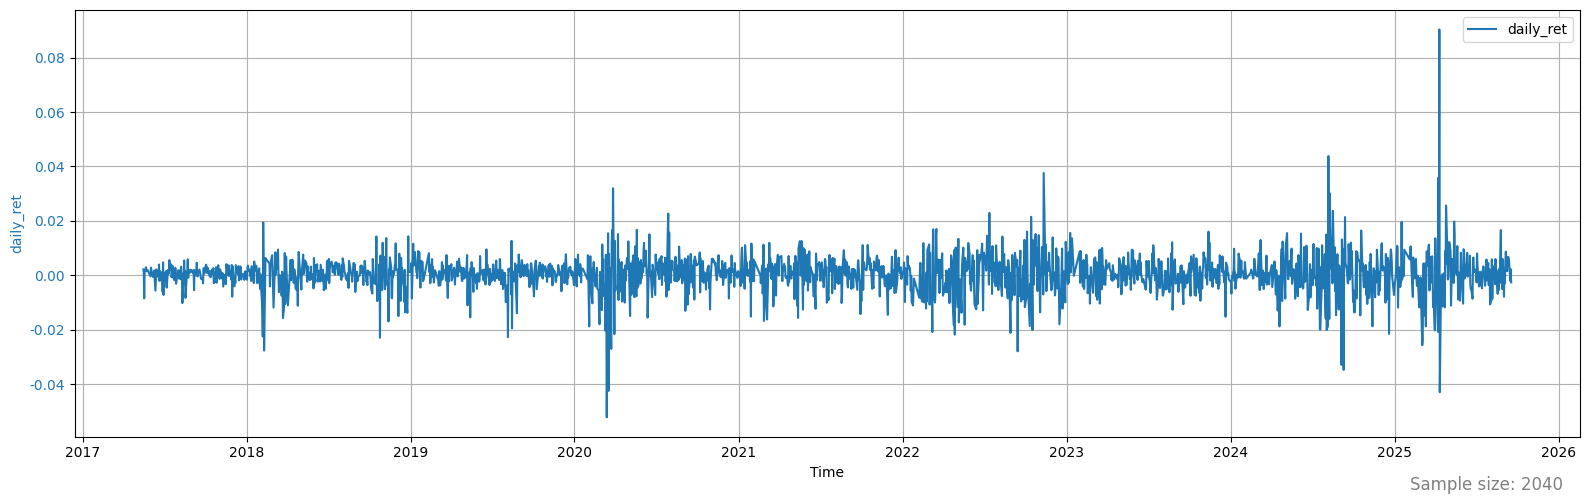

{'max_ly': None,
 'min_ly': None,
 'max_ry': None,
 'min_ry': None,
 'point_ly': None,
 'point_ry': None}

In [1469]:
plot(TXa_df, "daily_ret", "index")